In [3]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


In [4]:
log_z = np.log(states[:,2])

MU_X = np.mean(log_z)
signal = log_z-MU_X

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
BINS = 50

print(f'Signal length M={M}')

Signal length M=15000


In [5]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [6]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0).to(DEVICE)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(np.exp(signal[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          np.exp(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .9)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-4,4)
        ax1.legend()
        plt.show()
        fig.savefig(f'./Z_Saved_Models/Z_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_Wnet',wnet)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_Preds',yHat_GPU)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 1000 -- Run 0 ***********
Iter: 0 #### Diagnostic 1.510753   Time 11.89  Best 1000.000 NRMSE 0.508 CD 1.003
Iter: 1 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.003719   Time 6.98  Best 1000.000 NRMSE 0.182 CD 0.821
Iter: 5 #### Diagnostic 1000.000000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD 0.999
Iter: 6 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.25  Best 1000.000 NRMSE 1000.000 CD nan


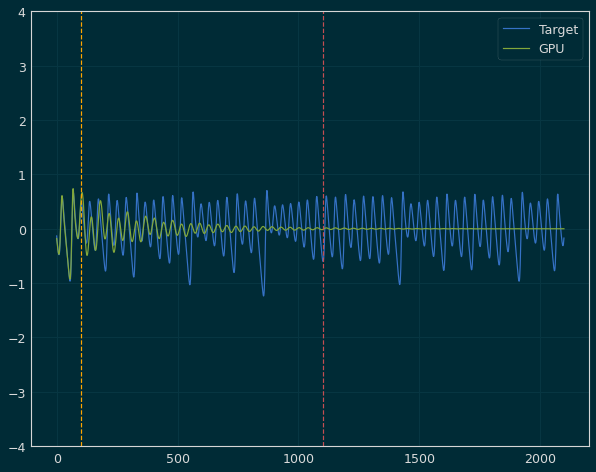

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.757766


Iter: 8 #### Diagnostic 0.757766   Time 8.34  Best 0.758 NRMSE 0.168 CD 0.590
Iter: 9 #### Diagnostic 1000.000000   Time 8.96  Best 0.758 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 6.43  Best 0.758 NRMSE 1000.000 CD 1.000
Iter: 11 #### Diagnostic 1000.000000   Time 6.25  Best 0.758 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 8.80  Best 0.758 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.995602   Time 7.60  Best 0.758 NRMSE 0.190 CD 0.806
Iter: 14 #### Diagnostic 1000.000000   Time 6.59  Best 0.758 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.056054   Time 8.27  Best 0.758 NRMSE 0.185 CD 0.871
Iter: 16 #### Diagnostic 1000.000000   Time 9.49  Best 0.758 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 9.50  Best 0.758 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 6.42  Best 0.758 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.07

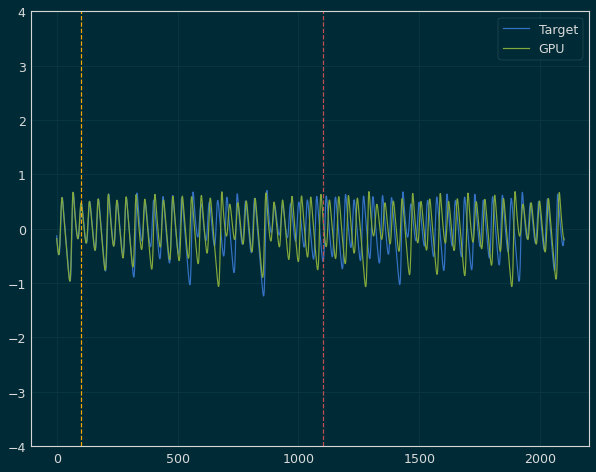

 Iter=73 a=0.401 sr=1.928 amp=0.870  ri=0.939 rr=0.361 loss=0.684778


Iter: 73 #### Diagnostic 0.684778   Time 8.26  Best 0.685 NRMSE 0.182 CD 0.503
Iter: 74 #### Diagnostic 1000.000000   Time 8.33  Best 0.685 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.974202   Time 7.26  Best 0.685 NRMSE 0.182 CD 0.793
Iter: 76 #### Diagnostic 1000.000000   Time 12.90  Best 0.685 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.146268   Time 5.49  Best 0.685 NRMSE 0.186 CD 0.960
Iter: 78 #### Diagnostic 1.128088   Time 6.74  Best 0.685 NRMSE 0.204 CD 0.924
Iter: 79 #### Diagnostic 1000.000000   Time 6.48  Best 0.685 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.60  Best 0.685 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.55  Best 0.685 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 6.50  Best 0.685 NRMSE 1000.000 CD 1.037
Iter: 83 #### Diagnostic 1.104651   Time 6.89  Best 0.685 NRMSE 0.207 CD 0.898
Iter: 84 #### Diagnostic 1000.000

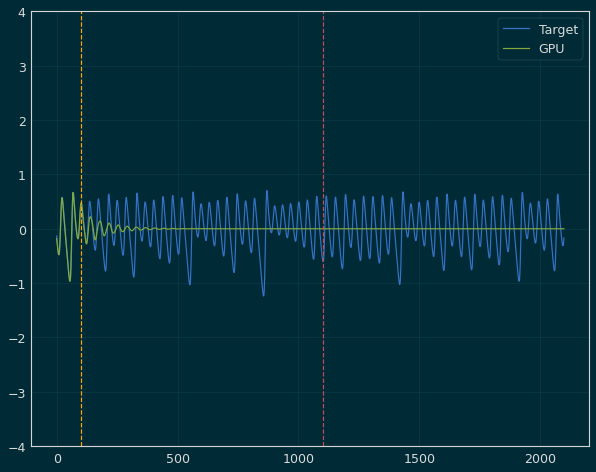

 Iter=12 a=0.615 sr=3.413 amp=0.193  ri=0.022 rr=4.454 loss=0.860125


Iter: 12 #### Diagnostic 0.860125   Time 6.62  Best 0.860 NRMSE 0.178 CD 0.682
Iter: 13 #### Diagnostic 1000.000000   Time 6.41  Best 0.860 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.17  Best 0.860 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.65  Best 0.860 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 10.09  Best 0.860 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.073452   Time 9.91  Best 0.860 NRMSE 0.184 CD 0.889
Iter: 18 #### Diagnostic 1000.000000   Time 13.17  Best 0.860 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 15.08  Best 0.860 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.995780   Time 11.92  Best 0.860 NRMSE 0.182 CD 0.813
Iter: 21 #### Diagnostic 1000.000000   Time 8.70  Best 0.860 NRMSE 1000.000 CD nan


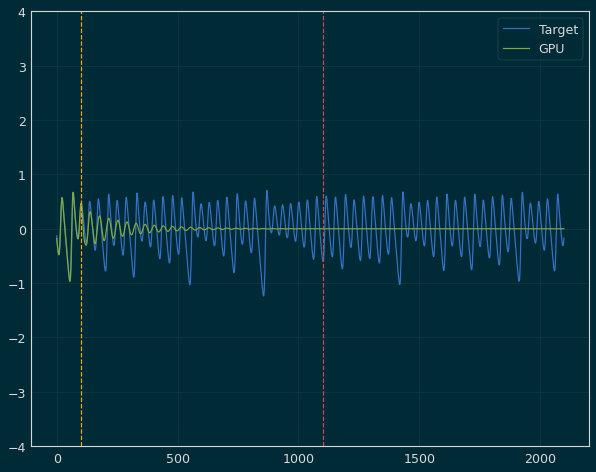

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.751248


Iter: 22 #### Diagnostic 0.751248   Time 8.61  Best 0.751 NRMSE 0.172 CD 0.580
Iter: 23 #### Diagnostic 1000.000000   Time 8.08  Best 0.751 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.542038   Time 13.93  Best 0.751 NRMSE 0.536 CD 1.006
Iter: 25 #### Diagnostic 0.867380   Time 9.63  Best 0.751 NRMSE 0.208 CD 0.659
Iter: 26 #### Diagnostic 1000.000000   Time 10.88  Best 0.751 NRMSE 1000.000 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 7.78  Best 0.751 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.214241   Time 10.80  Best 0.751 NRMSE 0.223 CD 0.991
Iter: 29 #### Diagnostic 1000.000000   Time 11.83  Best 0.751 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.88  Best 0.751 NRMSE 1000.000 CD 0.990
Iter: 31 #### Diagnostic 1.118105   Time 8.91  Best 0.751 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.146570   Time 6.56  Best 0.751 NRMSE 0.194 CD 0.952
Iter: 33 #### Diagnostic 1000.00

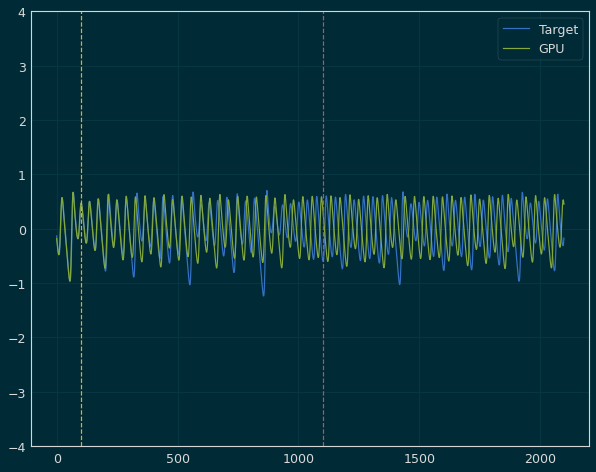

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.743450


Iter: 4 #### Diagnostic 0.743450   Time 18.07  Best 0.743 NRMSE 0.192 CD 0.551
Iter: 5 #### Diagnostic 1000.000000   Time 15.19  Best 0.743 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.537910   Time 16.34  Best 0.743 NRMSE 0.536 CD 1.002
Iter: 7 #### Diagnostic 1000.000000   Time 13.31  Best 0.743 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 17.78  Best 0.743 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 16.19  Best 0.743 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 13.43  Best 0.743 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.539871   Time 14.32  Best 0.743 NRMSE 0.536 CD 1.004
Iter: 12 #### Diagnostic 0.962466   Time 12.75  Best 0.743 NRMSE 0.221 CD 0.741
Iter: 13 #### Diagnostic 1.480735   Time 8.57  Best 0.743 NRMSE 0.486 CD 0.994
Iter: 14 #### Diagnostic 1.078142   Time 13.81  Best 0.743 NRMSE 0.184 CD 0.894
Iter: 15 #### Diagnostic 74.174534   

Iter: 0 #### Diagnostic 1000.000000   Time 11.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.532664   Time 17.44  Best 1000.000 NRMSE 0.536 CD 0.997
Iter: 3 #### Diagnostic 1000.000000   Time 20.04  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 4 #### Diagnostic 1000.000000   Time 9.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 10.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 16.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 16.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 21.50  Best 1000.000 NRMSE 1000.000 CD nan


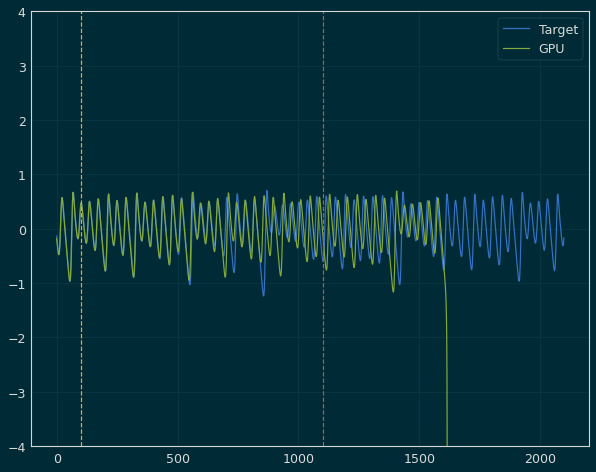

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.517596


Iter: 9 #### Diagnostic 0.517596   Time 14.43  Best 0.518 NRMSE 0.153 CD 0.365
Iter: 10 #### Diagnostic 1000.000000   Time 9.74  Best 0.518 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 12.89  Best 0.518 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 15.84  Best 0.518 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 15.74  Best 0.518 NRMSE 1000.000 CD 1.000
Iter: 14 #### Diagnostic 1.543092   Time 10.35  Best 0.518 NRMSE 0.536 CD 1.007
Iter: 15 #### Diagnostic 0.639842   Time 19.08  Best 0.518 NRMSE 0.166 CD 0.474
Iter: 16 #### Diagnostic 1000.000000   Time 16.38  Best 0.518 NRMSE 1000.000 CD nan


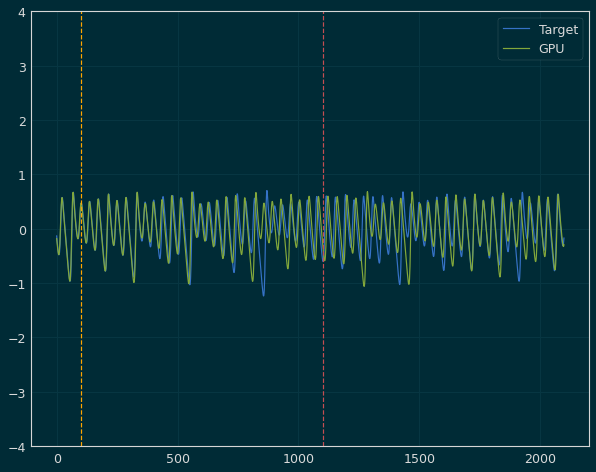

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.513667


Iter: 17 #### Diagnostic 0.513667   Time 18.01  Best 0.514 NRMSE 0.153 CD 0.361
Iter: 18 #### Diagnostic 0.956576   Time 10.49  Best 0.514 NRMSE 0.182 CD 0.775
Iter: 19 #### Diagnostic 1000.000000   Time 16.00  Best 0.514 NRMSE 1000.000 CD 0.998
Iter: 20 #### Diagnostic 1.155069   Time 16.90  Best 0.514 NRMSE 0.193 CD 0.962
Iter: 21 #### Diagnostic 1000.000000   Time 9.27  Best 0.514 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.544539   Time 16.77  Best 0.514 NRMSE 0.536 CD 1.009
Iter: 23 #### Diagnostic 1000.000000   Time 16.97  Best 0.514 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 15.64  Best 0.514 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 13.09  Best 0.514 NRMSE 1000.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 15.51  Best 0.514 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 15.74  Best 0.514 NRMSE 1000.000 CD nan
Iter: 28 #### Diag

Iter: 13 #### Diagnostic 1000.000000   Time 17.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 12.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 11.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 15.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.544420   Time 15.10  Best 1000.000 NRMSE 0.536 CD 1.009
Iter: 18 #### Diagnostic 1000.000000   Time 18.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 20.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 19.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.424354   Time 18.07  Best 1000.000 NRMSE 0.397 CD 1.027
Iter: 22 #### Diagnostic 1000.000000   Time 15.88  Best 1000.000 NRMSE 5006298240632162.000 CD 1.019
Iter: 23 #### Diagnostic 1000.000000   Time 17.09  Best 1000.000 NRMSE 15634075.331 CD 1.006
Iter: 24 #### Diagnostic 1000.0

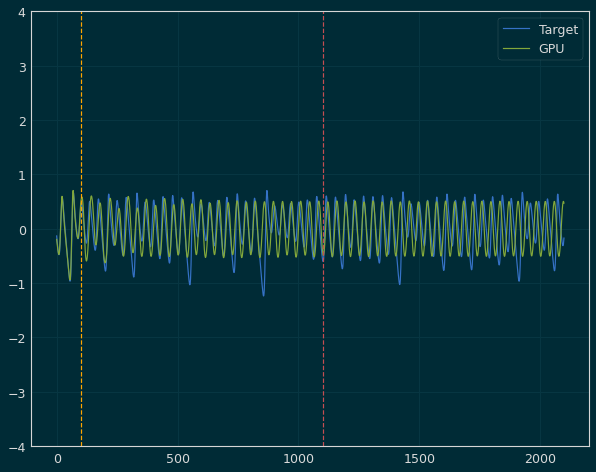

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.569029


Iter: 46 #### Diagnostic 0.569029   Time 19.92  Best 0.569 NRMSE 0.160 CD 0.409
Iter: 47 #### Diagnostic 1.538153   Time 16.01  Best 0.569 NRMSE 0.557 CD 0.981
Iter: 48 #### Diagnostic 1000.000000   Time 15.92  Best 0.569 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.179785   Time 10.98  Best 0.569 NRMSE 0.187 CD 0.993
Iter: 50 #### Diagnostic 1.290179   Time 15.67  Best 0.569 NRMSE 0.217 CD 1.073
Iter: 51 #### Diagnostic 1.249142   Time 18.26  Best 0.569 NRMSE 0.194 CD 1.055
Iter: 52 #### Diagnostic 1.250267   Time 9.34  Best 0.569 NRMSE 0.336 CD 0.914
Iter: 53 #### Diagnostic 1000.000000   Time 9.88  Best 0.569 NRMSE 1000.000 CD 0.973
Iter: 54 #### Diagnostic 1000.000000   Time 12.74  Best 0.569 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 14.56  Best 0.569 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 13.63  Best 0.569 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000

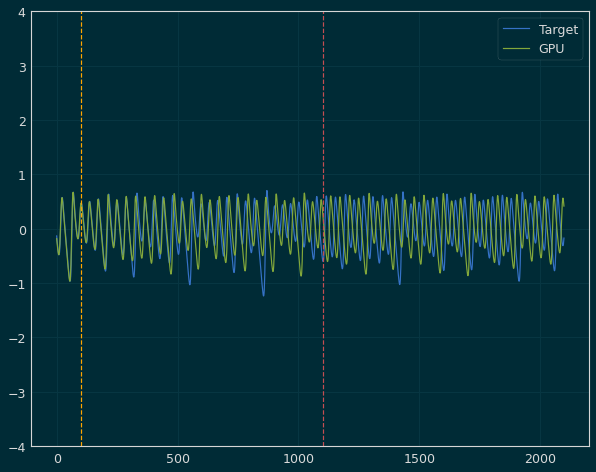

 Iter=0 a=0.069 sr=5.318 amp=0.195  ri=0.926 rr=0.527 loss=0.835448


Iter: 0 #### Diagnostic 0.835448   Time 18.06  Best 0.835 NRMSE 0.206 CD 0.630
Iter: 1 #### Diagnostic 1000.000000   Time 11.86  Best 0.835 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 18.79  Best 0.835 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 11.37  Best 0.835 NRMSE 1000.000 CD 0.988
Iter: 4 #### Diagnostic 1.014148   Time 13.92  Best 0.835 NRMSE 0.183 CD 0.831
Iter: 5 #### Diagnostic 1.539212   Time 14.26  Best 0.835 NRMSE 0.536 CD 1.003
Iter: 6 #### Diagnostic 1000.000000   Time 18.06  Best 0.835 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 17.02  Best 0.835 NRMSE 1000.000 CD nan


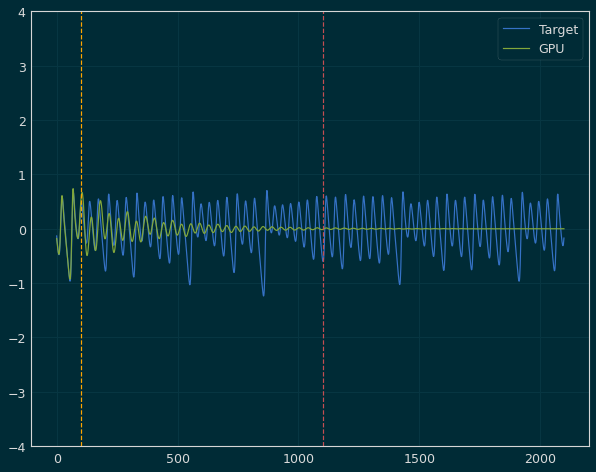

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.761821


Iter: 8 #### Diagnostic 0.761821   Time 18.84  Best 0.762 NRMSE 0.169 CD 0.593
Iter: 9 #### Diagnostic 1000.000000   Time 13.95  Best 0.762 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.535375   Time 16.09  Best 0.762 NRMSE 0.536 CD 1.000
Iter: 11 #### Diagnostic 1000.000000   Time 11.44  Best 0.762 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 17.44  Best 0.762 NRMSE 1000.000 CD 1.007
Iter: 13 #### Diagnostic 1.048793   Time 12.20  Best 0.762 NRMSE 0.194 CD 0.855
Iter: 14 #### Diagnostic 1000.000000   Time 18.86  Best 0.762 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.052652   Time 13.78  Best 0.762 NRMSE 0.185 CD 0.867
Iter: 16 #### Diagnostic 1000.000000   Time 13.57  Best 0.762 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 10.32  Best 0.762 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 18.16  Best 0.762 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnost

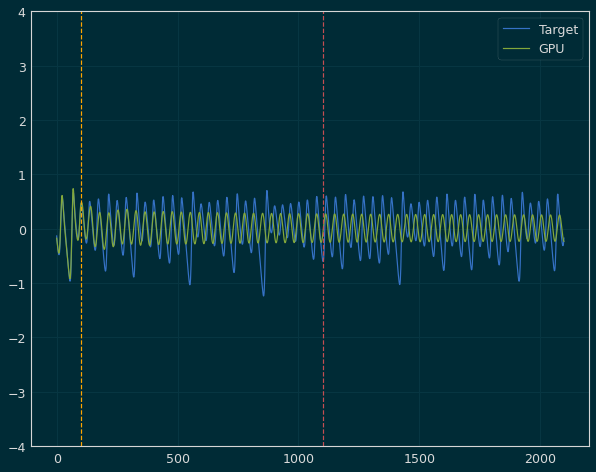

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.734337


Iter: 30 #### Diagnostic 0.734337   Time 15.44  Best 0.734 NRMSE 0.159 CD 0.575
Iter: 31 #### Diagnostic 1000.000000   Time 14.44  Best 0.734 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.101489   Time 14.26  Best 0.734 NRMSE 0.187 CD 0.915
Iter: 33 #### Diagnostic 1.543708   Time 15.98  Best 0.734 NRMSE 0.536 CD 1.008
Iter: 34 #### Diagnostic 1000.000000   Time 12.75  Best 0.734 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 13.60  Best 0.734 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 15.92  Best 0.734 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 13.40  Best 0.734 NRMSE 133396296890320338944.000 CD 0.993


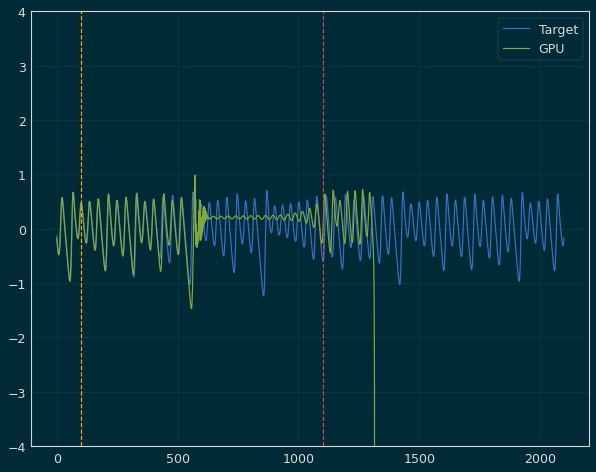

 Iter=38 a=0.607 sr=1.415 amp=0.921  ri=0.342 rr=1.015 loss=0.589894


Iter: 38 #### Diagnostic 0.589894   Time 17.00  Best 0.590 NRMSE 0.155 CD 0.435
Iter: 39 #### Diagnostic 1000.000000   Time 18.39  Best 0.590 NRMSE 1000.000 CD 0.953
Iter: 40 #### Diagnostic 1.045407   Time 12.69  Best 0.590 NRMSE 0.184 CD 0.862
Iter: 41 #### Diagnostic 1.116901   Time 14.62  Best 0.590 NRMSE 0.185 CD 0.932
Iter: 42 #### Diagnostic 1.111925   Time 12.12  Best 0.590 NRMSE 0.185 CD 0.927
Iter: 43 #### Diagnostic 1000.000000   Time 17.62  Best 0.590 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 16.81  Best 0.590 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 14.31  Best 0.590 NRMSE 136779190706461.969 CD 1.000
Iter: 46 #### Diagnostic 1000.000000   Time 15.86  Best 0.590 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 15.21  Best 0.590 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 15.60  Best 0.590 NRMSE 550802642386386112.000

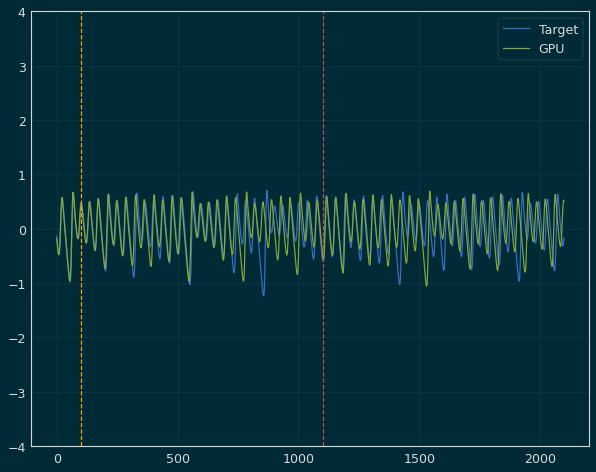

 Iter=11 a=0.259 sr=2.417 amp=0.513  ri=0.337 rr=3.816 loss=0.557747


Iter: 11 #### Diagnostic 0.557747   Time 17.94  Best 0.558 NRMSE 0.155 CD 0.403
Iter: 12 #### Diagnostic 0.868561   Time 14.26  Best 0.558 NRMSE 0.178 CD 0.690
Iter: 13 #### Diagnostic 1000.000000   Time 9.11  Best 0.558 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 14.98  Best 0.558 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 11.95  Best 0.558 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 16.65  Best 0.558 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.070436   Time 11.31  Best 0.558 NRMSE 0.184 CD 0.886
Iter: 18 #### Diagnostic 1000.000000   Time 15.12  Best 0.558 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 14.39  Best 0.558 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.997373   Time 10.91  Best 0.558 NRMSE 0.182 CD 0.815
Iter: 21 #### Diagnostic 1000.000000   Time 17.90  Best 0.558 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnost

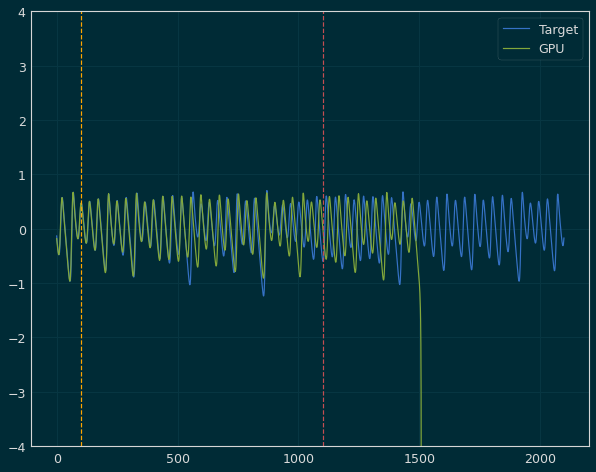

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.552982


Iter: 54 #### Diagnostic 0.552982   Time 15.09  Best 0.553 NRMSE 0.164 CD 0.389
Iter: 55 #### Diagnostic 1.545200   Time 18.32  Best 0.553 NRMSE 0.536 CD 1.009
Iter: 56 #### Diagnostic 0.639468   Time 17.17  Best 0.553 NRMSE 0.174 CD 0.466
Iter: 57 #### Diagnostic 1.059158   Time 17.15  Best 0.553 NRMSE 0.184 CD 0.875
Iter: 58 #### Diagnostic 1000.000000   Time 15.96  Best 0.553 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.756293   Time 17.61  Best 0.553 NRMSE 0.751 CD 1.006
Iter: 60 #### Diagnostic 1000.000000   Time 17.84  Best 0.553 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.734543   Time 17.09  Best 0.553 NRMSE 0.177 CD 0.558


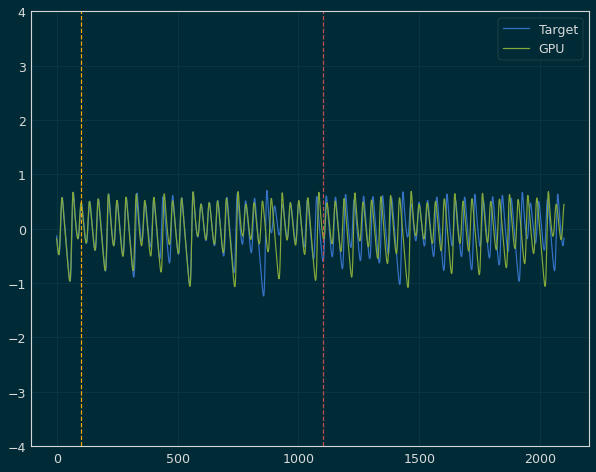

 Iter=62 a=0.706 sr=5.607 amp=0.238  ri=0.418 rr=0.894 loss=0.453601


Iter: 62 #### Diagnostic 0.453601   Time 18.65  Best 0.454 NRMSE 0.136 CD 0.317
Iter: 63 #### Diagnostic 1.257281   Time 19.16  Best 0.454 NRMSE 0.229 CD 1.029
Iter: 64 #### Diagnostic 1000.000000   Time 17.22  Best 0.454 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 11.24  Best 0.454 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 19.51  Best 0.454 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 13.71  Best 0.454 NRMSE 1000.000 CD 1.001
Iter: 68 #### Diagnostic 1000.000000   Time 14.05  Best 0.454 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 15.49  Best 0.454 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 13.21  Best 0.454 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.508925   Time 12.70  Best 0.454 NRMSE 0.507 CD 1.002
Iter: 72 #### Diagnostic 1000.000000   Time 16.98  Best 0.454 NRMSE 610786237731183488.000 CD 1.011

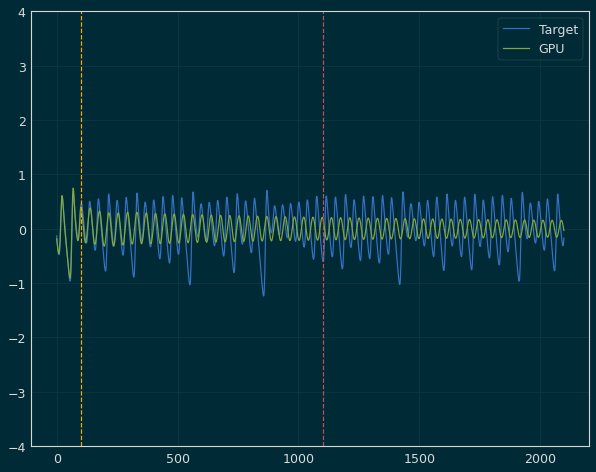

 Iter=48 a=0.026 sr=0.528 amp=0.327  ri=0.584 rr=0.504 loss=0.708423


Iter: 48 #### Diagnostic 0.708423   Time 11.84  Best 0.708 NRMSE 0.165 CD 0.544
Iter: 49 #### Diagnostic 1.187810   Time 13.63  Best 0.708 NRMSE 0.202 CD 0.985
Iter: 50 #### Diagnostic 1.538272   Time 13.19  Best 0.708 NRMSE 0.536 CD 1.002
Iter: 51 #### Diagnostic 1000.000000   Time 18.54  Best 0.708 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 13.25  Best 0.708 NRMSE 1000.000 CD 0.987
Iter: 53 #### Diagnostic 1.098013   Time 8.25  Best 0.708 NRMSE 0.185 CD 0.913
Iter: 54 #### Diagnostic 1.104311   Time 17.45  Best 0.708 NRMSE 0.185 CD 0.919
Iter: 55 #### Diagnostic 1.058997   Time 15.41  Best 0.708 NRMSE 0.184 CD 0.875
Iter: 56 #### Diagnostic 1000.000000   Time 12.87  Best 0.708 NRMSE 5844847.748 CD 1.017
Iter: 57 #### Diagnostic 1000.000000   Time 18.11  Best 0.708 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 15.94  Best 0.708 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnosti

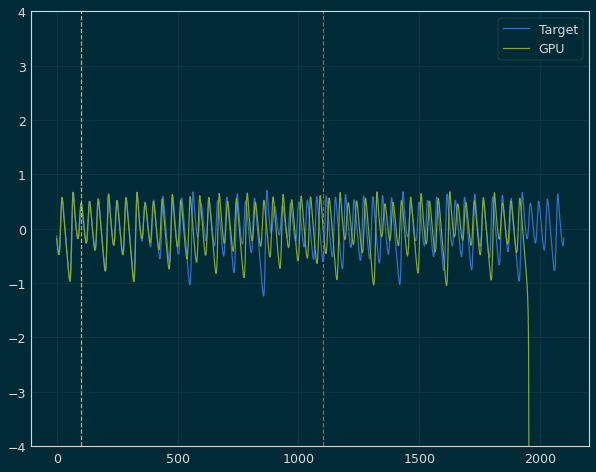

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.749606


Iter: 17 #### Diagnostic 0.749606   Time 20.51  Best 0.750 NRMSE 0.188 CD 0.561
Iter: 18 #### Diagnostic 0.944352   Time 13.19  Best 0.750 NRMSE 0.181 CD 0.763
Iter: 19 #### Diagnostic 1000.000000   Time 12.68  Best 0.750 NRMSE 1000.000 CD 0.997
Iter: 20 #### Diagnostic 1.178521   Time 12.59  Best 0.750 NRMSE 0.200 CD 0.979
Iter: 21 #### Diagnostic 1000.000000   Time 18.21  Best 0.750 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 19.42  Best 0.750 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.544453   Time 13.81  Best 0.750 NRMSE 0.536 CD 1.009
Iter: 24 #### Diagnostic 1000.000000   Time 20.61  Best 0.750 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 14.80  Best 0.750 NRMSE 74277780814481457609749561344.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 18.16  Best 0.750 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 15.33  Best 0.750 NRMSE 1000.000

Iter: 13 #### Diagnostic 1000.000000   Time 16.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 17.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 18.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 16.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 10.53  Best 1000.000 NRMSE 1000.000 CD 1.003
Iter: 18 #### Diagnostic 1000.000000   Time 15.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.544104   Time 16.31  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 20 #### Diagnostic 1000.000000   Time 19.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 15.78  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 22 #### Diagnostic 1000.000000   Time 18.07  Best 1000.000 NRMSE 103900291372793728.000 CD 1.073
Iter: 23 #### Diagnostic 1000.000000   Time 15.80  Best 1000.000 NRMSE 212573510891.400 CD 1.008
Iter: 24 #### Dia

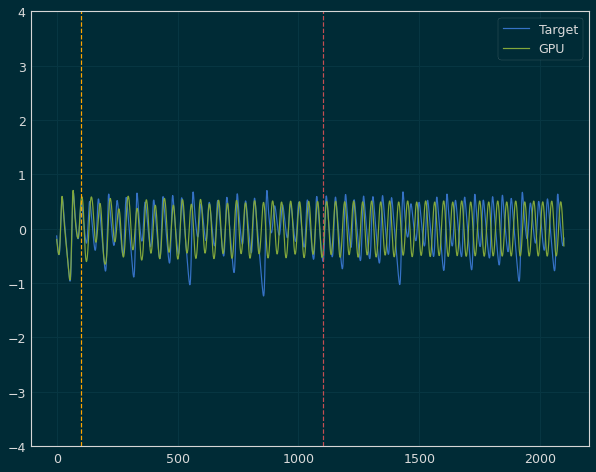

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.594070


Iter: 46 #### Diagnostic 0.594070   Time 10.52  Best 0.594 NRMSE 0.159 CD 0.435
Iter: 47 #### Diagnostic 1000.000000   Time 9.50  Best 0.594 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 10.68  Best 0.594 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.177680   Time 18.28  Best 0.594 NRMSE 0.187 CD 0.991
Iter: 50 #### Diagnostic 1.092886   Time 8.86  Best 0.594 NRMSE 0.216 CD 0.877
Iter: 51 #### Diagnostic 1.235072   Time 16.61  Best 0.594 NRMSE 0.194 CD 1.041
Iter: 52 #### Diagnostic 1.216167   Time 17.25  Best 0.594 NRMSE 0.323 CD 0.893
Iter: 53 #### Diagnostic 1000.000000   Time 12.70  Best 0.594 NRMSE 202590744084421936998429118427037696.000 CD 0.995
Iter: 54 #### Diagnostic 1000.000000   Time 14.52  Best 0.594 NRMSE 1000.000 CD 1.007
Iter: 55 #### Diagnostic 1000.000000   Time 13.13  Best 0.594 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 12.68  Best 0.594 NRMSE 1000.00

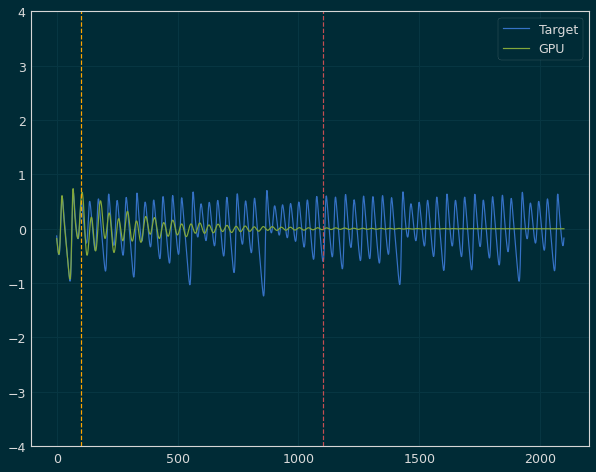

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.750712


Iter: 8 #### Diagnostic 0.750712   Time 13.15  Best 0.751 NRMSE 0.168 CD 0.583
Iter: 9 #### Diagnostic 1000.000000   Time 13.87  Best 0.751 NRMSE 1000.000 CD 0.961
Iter: 10 #### Diagnostic 1000.000000   Time 14.62  Best 0.751 NRMSE 1000.000 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 10.33  Best 0.751 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 16.01  Best 0.751 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.954245   Time 18.70  Best 0.751 NRMSE 0.187 CD 0.767
Iter: 14 #### Diagnostic 1000.000000   Time 18.19  Best 0.751 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.053948   Time 15.72  Best 0.751 NRMSE 0.185 CD 0.869
Iter: 16 #### Diagnostic 1000.000000   Time 13.56  Best 0.751 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 15.54  Best 0.751 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 10.52  Best 0.751 NRMSE 1000.000 CD nan
Iter: 19 #### Di

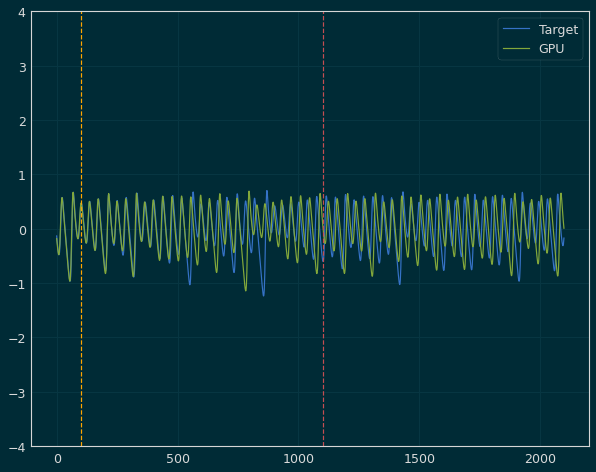

 Iter=60 a=0.415 sr=5.336 amp=0.264  ri=0.572 rr=3.962 loss=0.738350


Iter: 60 #### Diagnostic 0.738350   Time 15.79  Best 0.738 NRMSE 0.185 CD 0.554
Iter: 61 #### Diagnostic 1.543575   Time 12.40  Best 0.738 NRMSE 0.536 CD 1.008
Iter: 62 #### Diagnostic 1000.000000   Time 17.30  Best 0.738 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 18.66  Best 0.738 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 12.81  Best 0.738 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.111841   Time 11.92  Best 0.738 NRMSE 0.186 CD 0.926
Iter: 66 #### Diagnostic 1.153501   Time 18.96  Best 0.738 NRMSE 0.206 CD 0.947
Iter: 67 #### Diagnostic 1000.000000   Time 12.75  Best 0.738 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 15.42  Best 0.738 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 13.00  Best 0.738 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 15.62  Best 0.738 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnos

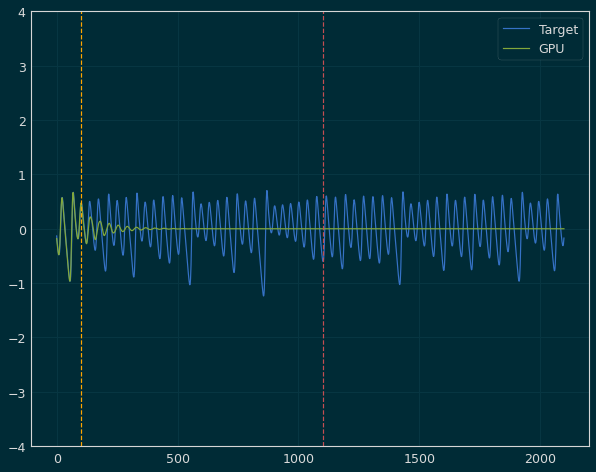

 Iter=12 a=0.615 sr=3.413 amp=0.193  ri=0.022 rr=4.454 loss=0.865797


Iter: 12 #### Diagnostic 0.865797   Time 15.76  Best 0.866 NRMSE 0.178 CD 0.687
Iter: 13 #### Diagnostic 1000.000000   Time 15.68  Best 0.866 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 16.62  Best 0.866 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 20.65  Best 0.866 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 16.53  Best 0.866 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.071605   Time 13.96  Best 0.866 NRMSE 0.184 CD 0.887
Iter: 18 #### Diagnostic 1000.000000   Time 15.71  Best 0.866 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.534397   Time 17.81  Best 0.866 NRMSE 0.536 CD 0.999
Iter: 20 #### Diagnostic 0.993908   Time 12.05  Best 0.866 NRMSE 0.182 CD 0.812
Iter: 21 #### Diagnostic 1000.000000   Time 15.66  Best 0.866 NRMSE 1000.000 CD nan


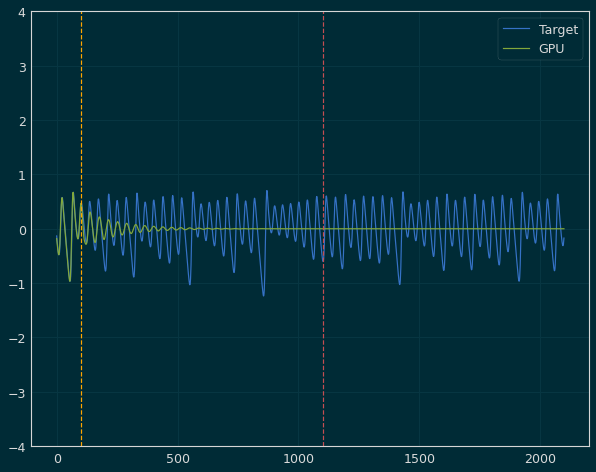

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.815329


Iter: 22 #### Diagnostic 0.815329   Time 17.13  Best 0.815 NRMSE 0.175 CD 0.640
Iter: 23 #### Diagnostic 1000.000000   Time 18.18  Best 0.815 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 16.10  Best 0.815 NRMSE 1000.000 CD 1.017
Iter: 25 #### Diagnostic 1000.000000   Time 15.87  Best 0.815 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.536158   Time 16.96  Best 0.815 NRMSE 0.536 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 17.01  Best 0.815 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 12.637250   Time 17.43  Best 0.815 NRMSE 11.668 CD 0.970
Iter: 29 #### Diagnostic 1000.000000   Time 8.39  Best 0.815 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 19.71  Best 0.815 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117870   Time 12.02  Best 0.815 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.147076   Time 9.79  Best 0.815 NRMSE 0.194 CD 0.953
Iter: 33 #### Diagnosti

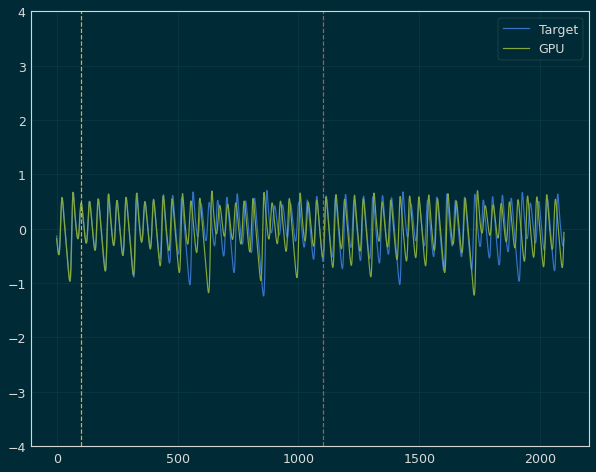

 Iter=61 a=0.458 sr=2.102 amp=0.657  ri=0.891 rr=4.684 loss=0.654381


Iter: 61 #### Diagnostic 0.654381   Time 14.18  Best 0.654 NRMSE 0.171 CD 0.483


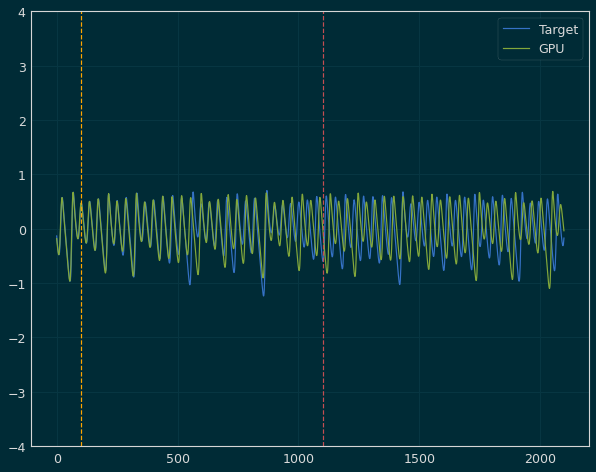

 Iter=62 a=0.706 sr=5.607 amp=0.238  ri=0.418 rr=0.894 loss=0.527330


Iter: 62 #### Diagnostic 0.527330   Time 17.35  Best 0.527 NRMSE 0.157 CD 0.370
Iter: 63 #### Diagnostic 1.193776   Time 10.63  Best 0.527 NRMSE 0.222 CD 0.972
Iter: 64 #### Diagnostic 1000.000000   Time 15.46  Best 0.527 NRMSE 1000.000 CD 0.997
Iter: 65 #### Diagnostic 1000.000000   Time 16.31  Best 0.527 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 12.30  Best 0.527 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 14.58  Best 0.527 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 16.64  Best 0.527 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 16.17  Best 0.527 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 15.14  Best 0.527 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 0.930409   Time 12.88  Best 0.527 NRMSE 0.221 CD 0.709
Iter: 72 #### Diagnostic 1000.000000   Time 18.35  Best 0.527 NRMSE 1000.000 CD nan
Iter: 73 #### D

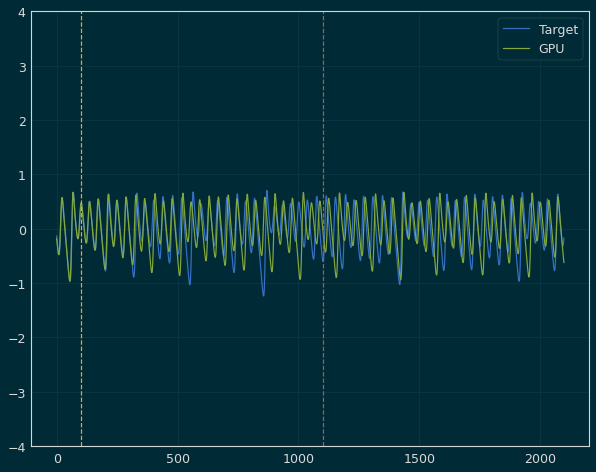

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.748565


Iter: 4 #### Diagnostic 0.748565   Time 16.08  Best 0.749 NRMSE 0.188 CD 0.561
Iter: 5 #### Diagnostic 1000.000000   Time 13.12  Best 0.749 NRMSE 606266.334 CD 0.992
Iter: 6 #### Diagnostic 1.533936   Time 18.61  Best 0.749 NRMSE 0.536 CD 0.998
Iter: 7 #### Diagnostic 1000.000000   Time 9.91  Best 0.749 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 13.44  Best 0.749 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 15.76  Best 0.749 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 16.66  Best 0.749 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 12.38  Best 0.749 NRMSE 1000.000 CD 0.992
Iter: 12 #### Diagnostic 1000.000000   Time 13.61  Best 0.749 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.880117   Time 15.80  Best 0.749 NRMSE 0.213 CD 0.667
Iter: 14 #### Diagnostic 1.072337   Time 15.18  Best 0.749 NRMSE 0.184 CD 0.888
Iter: 15 #### Diagnosti

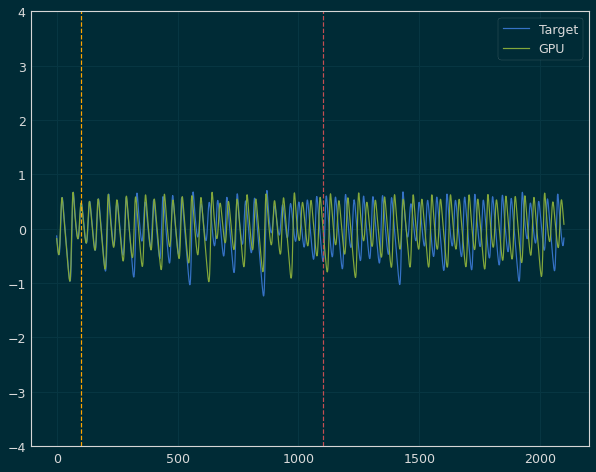

 Iter=17 a=0.362 sr=4.209 amp=0.425  ri=0.820 rr=2.857 loss=0.709680


Iter: 17 #### Diagnostic 0.709680   Time 14.18  Best 0.710 NRMSE 0.187 CD 0.523
Iter: 18 #### Diagnostic 1000.000000   Time 14.23  Best 0.710 NRMSE 3776707519338108153757696.000 CD 1.025
Iter: 19 #### Diagnostic 1000.000000   Time 17.20  Best 0.710 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.498652   Time 19.87  Best 0.710 NRMSE 0.475 CD 1.024
Iter: 21 #### Diagnostic 1.133940   Time 18.61  Best 0.710 NRMSE 0.191 CD 0.943
Iter: 22 #### Diagnostic 1000.000000   Time 10.83  Best 0.710 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.160860   Time 12.82  Best 0.710 NRMSE 0.225 CD 0.936


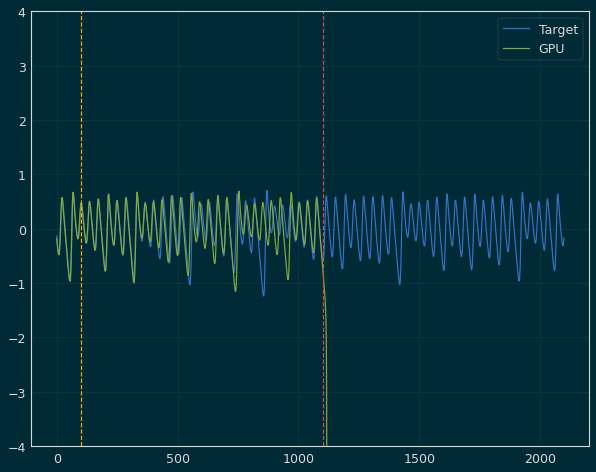

 Iter=24 a=0.277 sr=2.015 amp=0.898  ri=0.835 rr=0.732 loss=0.526610


Iter: 24 #### Diagnostic 0.526610   Time 21.81  Best 0.527 NRMSE 0.151 CD 0.375
Iter: 25 #### Diagnostic 1000.000000   Time 15.30  Best 0.527 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 9.28  Best 0.527 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 16.64  Best 0.527 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 16.04  Best 0.527 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 12.22  Best 0.527 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.541920   Time 15.24  Best 0.527 NRMSE 0.536 CD 1.006
Iter: 31 #### Diagnostic 1000.000000   Time 16.77  Best 0.527 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.187618   Time 17.43  Best 0.527 NRMSE 0.210 CD 0.977
Iter: 33 #### Diagnostic 1.057356   Time 20.64  Best 0.527 NRMSE 0.184 CD 0.874
Iter: 34 #### Diagnostic 1000.000000   Time 16.29  Best 0.527 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnost

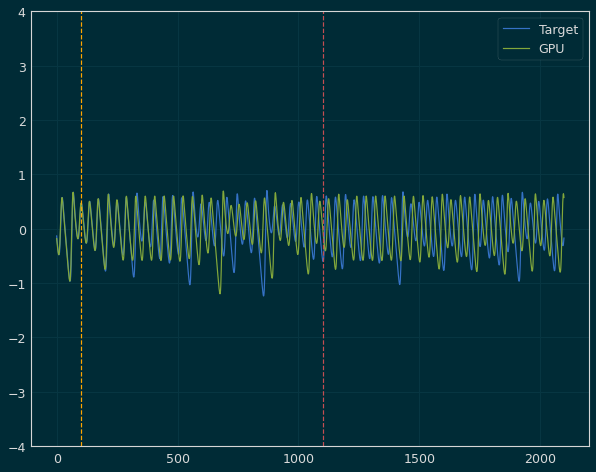

 Iter=15 a=0.555 sr=7.115 amp=0.184  ri=0.316 rr=0.371 loss=0.870695


Iter: 15 #### Diagnostic 0.870695   Time 18.21  Best 0.871 NRMSE 0.206 CD 0.665
Iter: 16 #### Diagnostic 1000.000000   Time 16.10  Best 0.871 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.496776   Time 11.94  Best 0.871 NRMSE 0.475 CD 1.022
Iter: 18 #### Diagnostic 0.940773   Time 17.60  Best 0.871 NRMSE 0.181 CD 0.760
Iter: 19 #### Diagnostic 1000.000000   Time 10.28  Best 0.871 NRMSE 1000.000 CD 0.995
Iter: 20 #### Diagnostic 1.171506   Time 16.97  Best 0.871 NRMSE 0.195 CD 0.976
Iter: 21 #### Diagnostic 1000.000000   Time 11.59  Best 0.871 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 18.57  Best 0.871 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 16.83  Best 0.871 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 17.43  Best 0.871 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.542177   Time 17.22  Best 0.871 NRMSE 0.536 CD 1.006
Iter: 26 #### Diagnosti

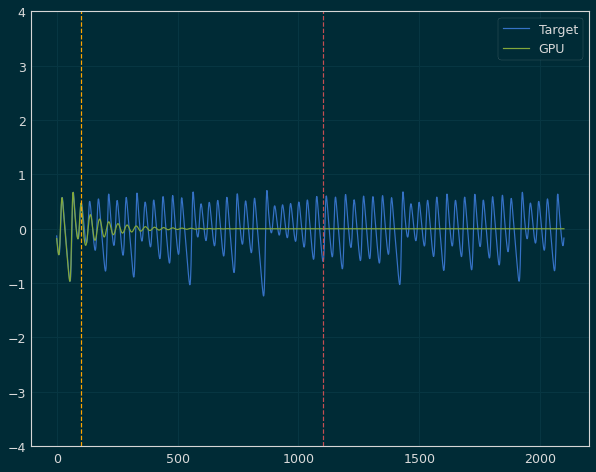

 Iter=29 a=0.801 sr=2.477 amp=0.069  ri=0.625 rr=0.775 loss=0.819930


Iter: 29 #### Diagnostic 0.819930   Time 16.13  Best 0.820 NRMSE 0.176 CD 0.644
Iter: 30 #### Diagnostic 1.542887   Time 14.40  Best 0.820 NRMSE 0.536 CD 1.007
Iter: 31 #### Diagnostic 1000.000000   Time 13.40  Best 0.820 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 15.25  Best 0.820 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 14.16  Best 0.820 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 11.46  Best 0.820 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 14.23  Best 0.820 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.565113   Time 12.99  Best 0.820 NRMSE 0.536 CD 1.029
Iter: 37 #### Diagnostic 1.108793   Time 15.46  Best 0.820 NRMSE 0.185 CD 0.924
Iter: 38 #### Diagnostic 1.147908   Time 14.68  Best 0.820 NRMSE 0.195 CD 0.953
Iter: 39 #### Diagnostic 1.067333   Time 17.57  Best 0.820 NRMSE 0.184 CD 0.883
Iter: 40 #### Diagnostic 1.13

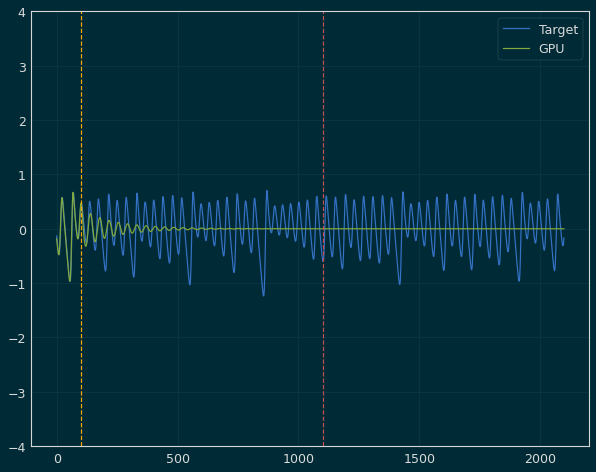

 Iter=92 a=0.788 sr=0.440 amp=0.213  ri=0.521 rr=0.831 loss=0.777280


Iter: 92 #### Diagnostic 0.777280   Time 19.08  Best 0.777 NRMSE 0.174 CD 0.603
Iter: 93 #### Diagnostic 1000.000000   Time 14.80  Best 0.777 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 11.34  Best 0.777 NRMSE 692716436.034 CD 0.993
Iter: 95 #### Diagnostic 1000.000000   Time 15.08  Best 0.777 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 10.71  Best 0.777 NRMSE 96296176302.106 CD 0.992
Iter: 97 #### Diagnostic 1000.000000   Time 18.51  Best 0.777 NRMSE 1000.000 CD 1.004
Iter: 98 #### Diagnostic 1000.000000   Time 16.82  Best 0.777 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 14.26  Best 0.777 NRMSE 1000.000 CD nan

Best result = 0.7772796556904472
a = 0.7881194796016651
sr = 0.44025376441432623
amp = 0.21290091456934396
ri = 0.5214664848597053
rr = 0.8312119900182274
********** Size 1000 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.544409   Time 14.98

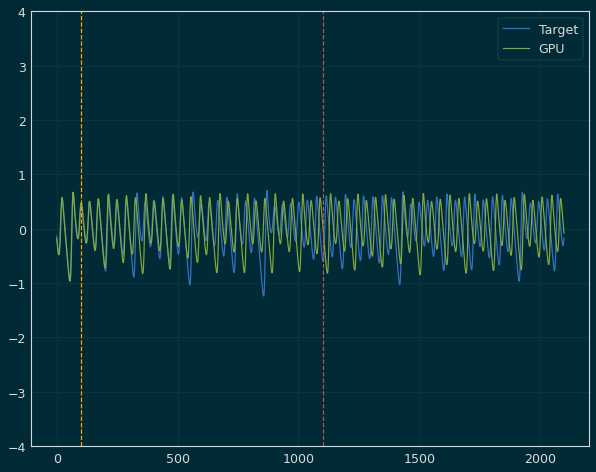

 Iter=1 a=0.539 sr=2.567 amp=0.750  ri=0.287 rr=1.974 loss=0.796004


Iter: 1 #### Diagnostic 0.796004   Time 16.51  Best 0.796 NRMSE 0.195 CD 0.601
Iter: 2 #### Diagnostic 1000.000000   Time 11.14  Best 0.796 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 13.52  Best 0.796 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 13.25  Best 0.796 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 13.45  Best 0.796 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 18.32  Best 0.796 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.540614   Time 13.93  Best 0.796 NRMSE 0.535 CD 1.006
Iter: 8 #### Diagnostic 0.969083   Time 11.36  Best 0.796 NRMSE 0.181 CD 0.788
Iter: 9 #### Diagnostic 1000.000000   Time 15.51  Best 0.796 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 12.27  Best 0.796 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 15.64  Best 0.796 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.

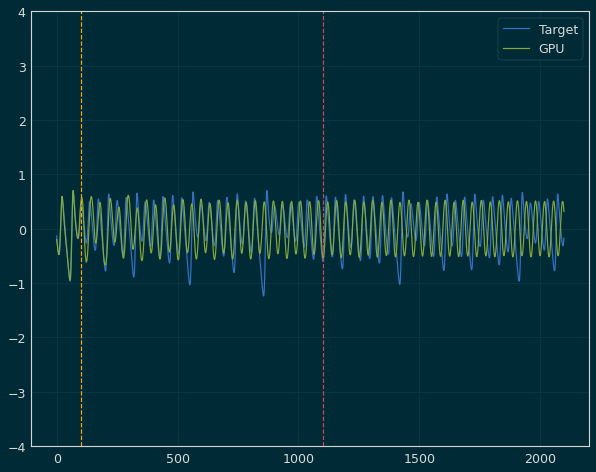

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.586679


Iter: 46 #### Diagnostic 0.586679   Time 12.41  Best 0.587 NRMSE 0.163 CD 0.424
Iter: 47 #### Diagnostic 1000.000000   Time 21.16  Best 0.587 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 12.04  Best 0.587 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.178331   Time 15.28  Best 0.587 NRMSE 0.187 CD 0.991
Iter: 50 #### Diagnostic 1.090564   Time 17.93  Best 0.587 NRMSE 0.213 CD 0.878
Iter: 51 #### Diagnostic 1.247059   Time 18.36  Best 0.587 NRMSE 0.193 CD 1.054
Iter: 52 #### Diagnostic 1.255242   Time 15.75  Best 0.587 NRMSE 0.320 CD 0.935
Iter: 53 #### Diagnostic 1000.000000   Time 9.07  Best 0.587 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 15.22  Best 0.587 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 14.59  Best 0.587 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 16.66  Best 0.587 NRMSE 13046798619244807323648.000 CD 0.998
Iter:

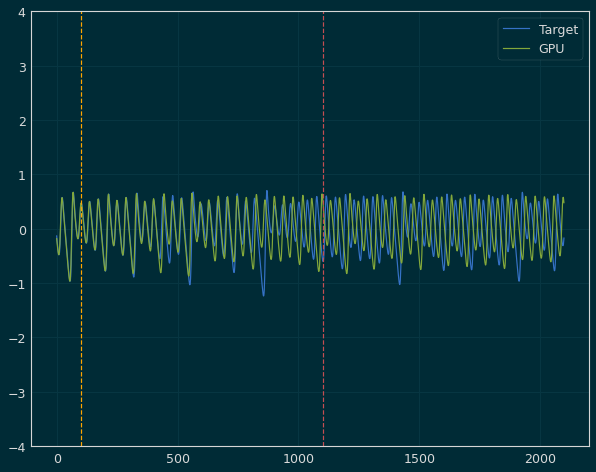

 Iter=0 a=0.069 sr=5.318 amp=0.195  ri=0.926 rr=0.527 loss=0.636155


Iter: 0 #### Diagnostic 0.636155   Time 18.59  Best 0.636 NRMSE 0.174 CD 0.462
Iter: 1 #### Diagnostic 1000.000000   Time 15.46  Best 0.636 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 16.17  Best 0.636 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 18.07  Best 0.636 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.012522   Time 14.85  Best 0.636 NRMSE 0.183 CD 0.830
Iter: 5 #### Diagnostic 1000.000000   Time 7.95  Best 0.636 NRMSE 1000.000 CD 0.993
Iter: 6 #### Diagnostic 1000.000000   Time 21.60  Best 0.636 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 17.25  Best 0.636 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.743971   Time 17.73  Best 0.636 NRMSE 0.167 CD 0.577
Iter: 9 #### Diagnostic 1000.000000   Time 13.83  Best 0.636 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.534162   Time 11.74  Best 0.636 NRMSE 0.536 CD 0.998
Iter: 11 #### Diagnostic 1000.0

Iter: 98 #### Diagnostic 1.081328   Time 10.87  Best 0.636 NRMSE 0.184 CD 0.897
Iter: 99 #### Diagnostic 1.147605   Time 20.56  Best 0.636 NRMSE 0.188 CD 0.960

Best result = 0.636154754914356
a = 0.0692385342602116
sr = 5.318097801381984
amp = 0.1949215061605647
ri = 0.9263566773666696
rr = 0.526770605032519
********** Size 1000 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 11.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.537901   Time 13.98  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 2 #### Diagnostic 1.099672   Time 19.32  Best 1000.000 NRMSE 0.185 CD 0.915
Iter: 3 #### Diagnostic 1000.000000   Time 16.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 15.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 13.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 18.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.192641   Time 10.90  Best 1

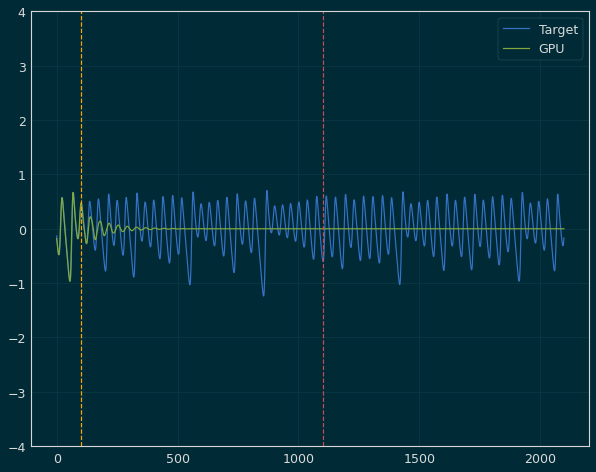

 Iter=12 a=0.615 sr=3.413 amp=0.193  ri=0.022 rr=4.454 loss=0.862418


Iter: 12 #### Diagnostic 0.862418   Time 10.02  Best 0.862 NRMSE 0.178 CD 0.684
Iter: 13 #### Diagnostic 1000.000000   Time 16.05  Best 0.862 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 14.91  Best 0.862 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 18.14  Best 0.862 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 20.52  Best 0.862 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.069560   Time 18.99  Best 0.862 NRMSE 0.184 CD 0.885
Iter: 18 #### Diagnostic 1000.000000   Time 16.08  Best 0.862 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 16.15  Best 0.862 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.992206   Time 18.48  Best 0.862 NRMSE 0.182 CD 0.810
Iter: 21 #### Diagnostic 1000.000000   Time 13.85  Best 0.862 NRMSE 1000.000 CD nan


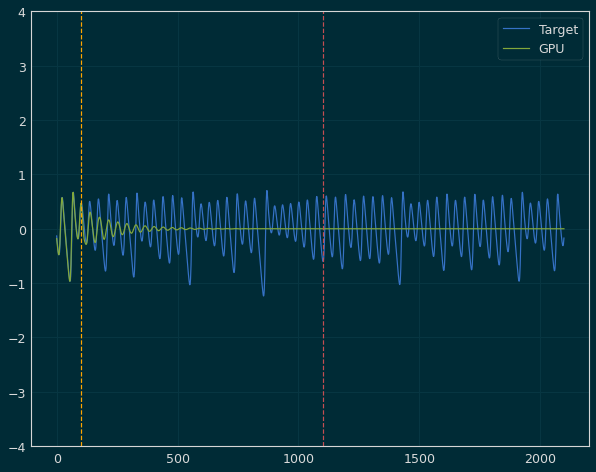

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.798879


Iter: 22 #### Diagnostic 0.798879   Time 18.20  Best 0.799 NRMSE 0.174 CD 0.624
Iter: 23 #### Diagnostic 1000.000000   Time 16.36  Best 0.799 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 17.97  Best 0.799 NRMSE 1000.000 CD 0.990
Iter: 25 #### Diagnostic 1000.000000   Time 16.38  Best 0.799 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 11.03  Best 0.799 NRMSE 1000.000 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 15.22  Best 0.799 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 15.89  Best 0.799 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 14.53  Best 0.799 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 15.94  Best 0.799 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.118488   Time 17.37  Best 0.799 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.160734   Time 9.12  Best 0.799 NRMSE 0.194 CD 0.966
Iter: 33 #### 

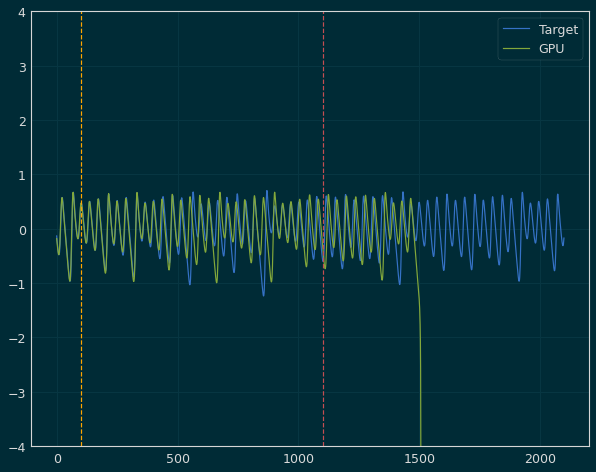

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.657129


Iter: 54 #### Diagnostic 0.657129   Time 15.07  Best 0.657 NRMSE 0.169 CD 0.488
Iter: 55 #### Diagnostic 1000.000000   Time 16.53  Best 0.657 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 19.09  Best 0.657 NRMSE 147161035248262.312 CD 0.994
Iter: 57 #### Diagnostic 1.061660   Time 8.51  Best 0.657 NRMSE 0.184 CD 0.878
Iter: 58 #### Diagnostic 1000.000000   Time 14.53  Best 0.657 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 14.00  Best 0.657 NRMSE 1000.000 CD 0.994
Iter: 60 #### Diagnostic 1000.000000   Time 13.19  Best 0.657 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.661061   Time 13.11  Best 0.657 NRMSE 0.174 CD 0.487
Iter: 62 #### Diagnostic 1000.000000   Time 15.88  Best 0.657 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.237515   Time 15.72  Best 0.657 NRMSE 0.227 CD 1.010
Iter: 64 #### Diagnostic 1000.000000   Time 13.45  Best 0.657 NRMSE 1000.000 CD nan
Iter: 6

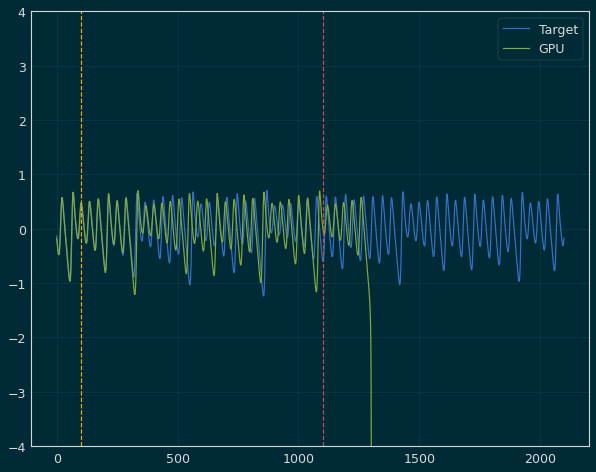

 Iter=11 a=0.363 sr=4.129 amp=0.458  ri=0.809 rr=1.582 loss=0.886488


Iter: 11 #### Diagnostic 0.886488   Time 18.65  Best 0.886 NRMSE 0.215 CD 0.671
Iter: 12 #### Diagnostic 1000.000000   Time 17.97  Best 0.886 NRMSE 16439610124193987821568.000 CD 0.993


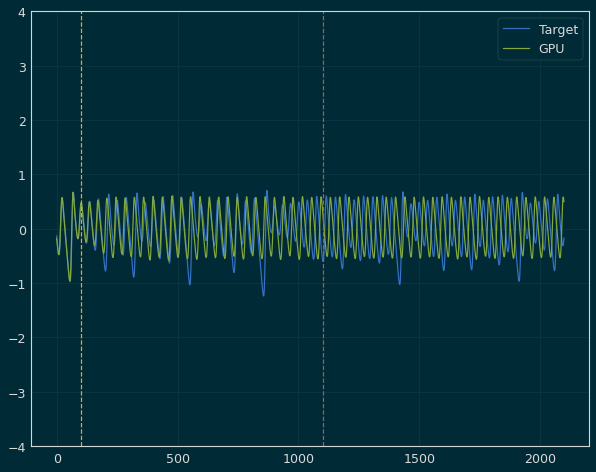

 Iter=13 a=0.143 sr=2.419 amp=0.807  ri=0.320 rr=0.107 loss=0.838372


Iter: 13 #### Diagnostic 0.838372   Time 17.14  Best 0.838 NRMSE 0.204 CD 0.635
Iter: 14 #### Diagnostic 1.088223   Time 14.12  Best 0.838 NRMSE 0.185 CD 0.904
Iter: 15 #### Diagnostic 1000.000000   Time 13.44  Best 0.838 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 0.958995   Time 12.70  Best 0.838 NRMSE 0.181 CD 0.778
Iter: 17 #### Diagnostic 1.541824   Time 14.12  Best 0.838 NRMSE 0.536 CD 1.006
Iter: 18 #### Diagnostic 1000.000000   Time 15.73  Best 0.838 NRMSE 15963262216366056.000 CD 0.992
Iter: 19 #### Diagnostic 1000.000000   Time 16.09  Best 0.838 NRMSE 1000.000 CD nan


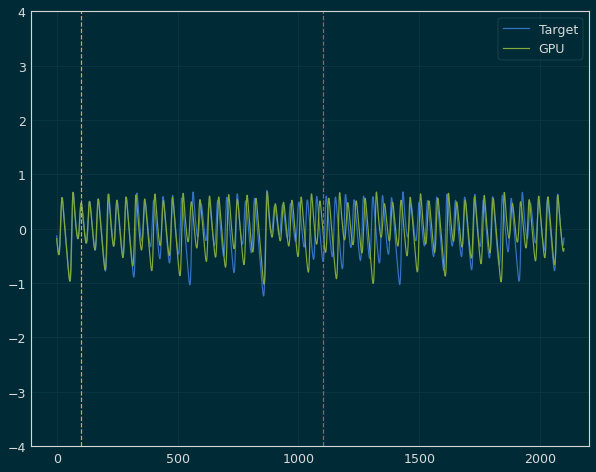

 Iter=20 a=0.234 sr=1.624 amp=0.958  ri=0.766 rr=0.942 loss=0.606886


Iter: 20 #### Diagnostic 0.606886   Time 12.46  Best 0.607 NRMSE 0.171 CD 0.435
Iter: 21 #### Diagnostic 0.998652   Time 13.40  Best 0.607 NRMSE 0.182 CD 0.816
Iter: 22 #### Diagnostic 1000.000000   Time 12.29  Best 0.607 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.229800   Time 16.30  Best 0.607 NRMSE 0.236 CD 0.994
Iter: 24 #### Diagnostic 0.799689   Time 14.14  Best 0.607 NRMSE 0.193 CD 0.606
Iter: 25 #### Diagnostic 1000.000000   Time 14.36  Best 0.607 NRMSE 221136089392.714 CD 0.999
Iter: 26 #### Diagnostic 1000.000000   Time 12.97  Best 0.607 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 12.12  Best 0.607 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 12.60  Best 0.607 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 16.59  Best 0.607 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 15.84  Best 0.607 NRMSE 1000.000 CD nan
Iter: 31 ##

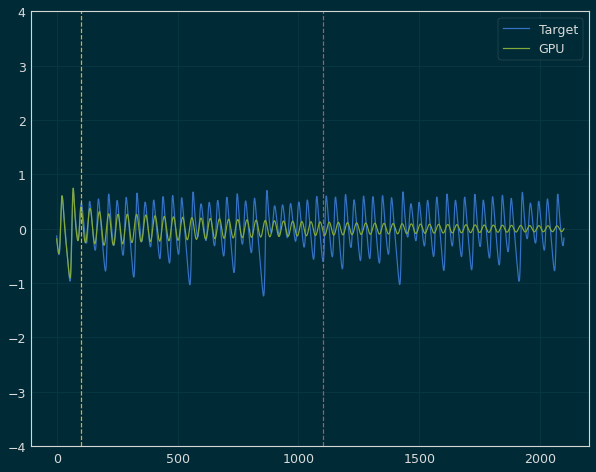

 Iter=48 a=0.026 sr=0.528 amp=0.327  ri=0.584 rr=0.504 loss=0.538385


Iter: 48 #### Diagnostic 0.538385   Time 16.68  Best 0.538 NRMSE 0.149 CD 0.389
Iter: 49 #### Diagnostic 1.111919   Time 14.51  Best 0.538 NRMSE 0.187 CD 0.925
Iter: 50 #### Diagnostic 1000.000000   Time 12.07  Best 0.538 NRMSE 1000.000 CD 1.002
Iter: 51 #### Diagnostic 1000.000000   Time 11.60  Best 0.538 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.535801   Time 15.74  Best 0.538 NRMSE 0.536 CD 1.000
Iter: 53 #### Diagnostic 1.089568   Time 9.71  Best 0.538 NRMSE 0.185 CD 0.905
Iter: 54 #### Diagnostic 1.103802   Time 11.76  Best 0.538 NRMSE 0.185 CD 0.919
Iter: 55 #### Diagnostic 1.063110   Time 16.12  Best 0.538 NRMSE 0.184 CD 0.879
Iter: 56 #### Diagnostic 1000.000000   Time 13.61  Best 0.538 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 23.17  Best 0.538 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 16.49  Best 0.538 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.0

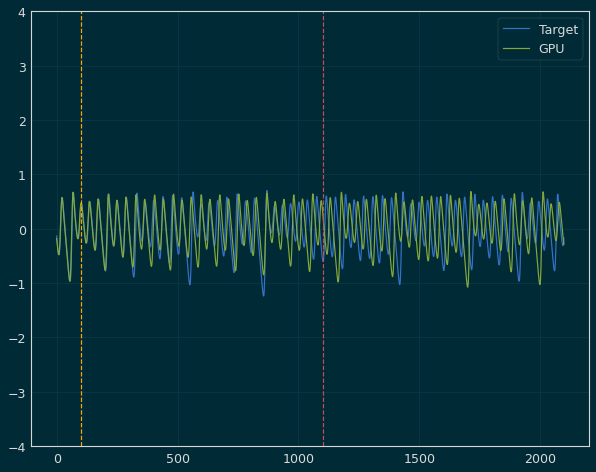

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.678125


Iter: 9 #### Diagnostic 0.678125   Time 16.64  Best 0.678 NRMSE 0.186 CD 0.492
Iter: 10 #### Diagnostic 1.142635   Time 17.19  Best 0.678 NRMSE 0.187 CD 0.956
Iter: 11 #### Diagnostic 1000.000000   Time 11.06  Best 0.678 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 18.35  Best 0.678 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.533201   Time 17.13  Best 0.678 NRMSE 0.536 CD 0.997
Iter: 14 #### Diagnostic 1000.000000   Time 17.19  Best 0.678 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 13.05  Best 0.678 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 11.48  Best 0.678 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.933639   Time 14.47  Best 0.678 NRMSE 0.214 CD 0.720
Iter: 18 #### Diagnostic 0.963406   Time 18.01  Best 0.678 NRMSE 0.182 CD 0.782
Iter: 19 #### Diagnostic 1.540193   Time 11.95  Best 0.678 NRMSE 0.536 CD 1.004
Iter: 20 #### Diagnostic 1.1656

Iter: 5 #### Diagnostic 1000.000000   Time 8.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 13.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.540710   Time 13.31  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 8 #### Diagnostic 0.982949   Time 16.49  Best 1000.000 NRMSE 0.181 CD 0.802
Iter: 9 #### Diagnostic 1000.000000   Time 17.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 12.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.118604   Time 11.40  Best 1000.000 NRMSE 0.210 CD 0.909
Iter: 12 #### Diagnostic 1000.000000   Time 15.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.535801   Time 17.62  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 11.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 16.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 11.34  Best 1000.000 

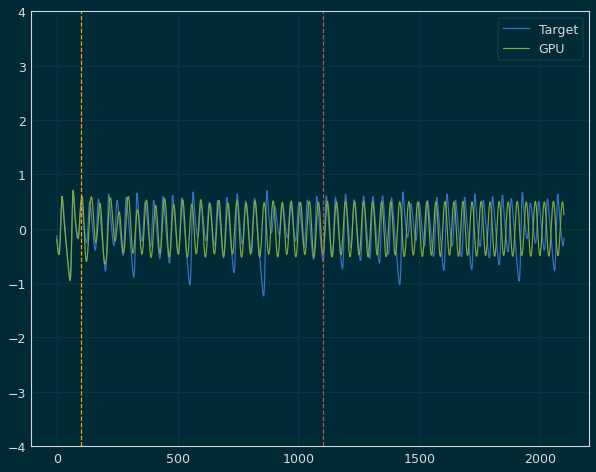

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.559069


Iter: 46 #### Diagnostic 0.559069   Time 17.75  Best 0.559 NRMSE 0.157 CD 0.402
Iter: 47 #### Diagnostic 1000.000000   Time 11.60  Best 0.559 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 17.22  Best 0.559 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.179287   Time 10.56  Best 0.559 NRMSE 0.187 CD 0.992
Iter: 50 #### Diagnostic 1.109419   Time 18.86  Best 0.559 NRMSE 0.213 CD 0.897
Iter: 51 #### Diagnostic 1.257523   Time 16.77  Best 0.559 NRMSE 0.194 CD 1.063
Iter: 52 #### Diagnostic 1.464766   Time 16.33  Best 0.559 NRMSE 0.378 CD 1.087
Iter: 53 #### Diagnostic 1.543923   Time 16.54  Best 0.559 NRMSE 0.536 CD 1.008
Iter: 54 #### Diagnostic 1000.000000   Time 18.87  Best 0.559 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 9.32  Best 0.559 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.555882   Time 13.85  Best 0.559 NRMSE 0.536 CD 1.020
Iter: 57 #### Diagnostic 1000.0000

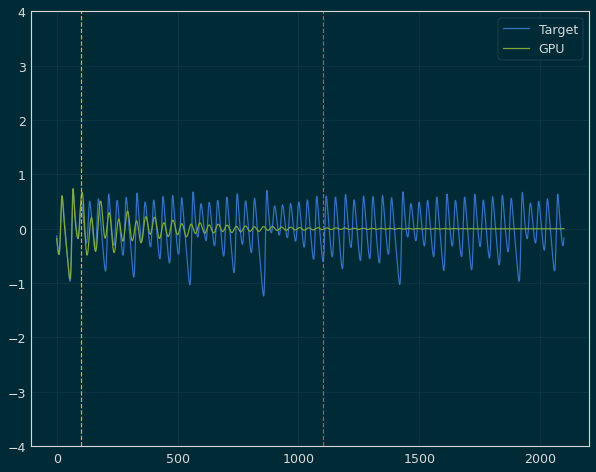

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.742706


Iter: 8 #### Diagnostic 0.742706   Time 18.33  Best 0.743 NRMSE 0.167 CD 0.575
Iter: 9 #### Diagnostic 1000.000000   Time 11.76  Best 0.743 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 17.79  Best 0.743 NRMSE 1000.000 CD 1.006
Iter: 11 #### Diagnostic 1000.000000   Time 11.54  Best 0.743 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 16.41  Best 0.743 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.943255   Time 12.82  Best 0.743 NRMSE 0.187 CD 0.756
Iter: 14 #### Diagnostic 1000.000000   Time 9.13  Best 0.743 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.056608   Time 16.74  Best 0.743 NRMSE 0.185 CD 0.871
Iter: 16 #### Diagnostic 1000.000000   Time 14.23  Best 0.743 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 17.64  Best 0.743 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 15.77  Best 0.743 NRMSE 1000.000 CD nan
Iter: 19 #### Diagn

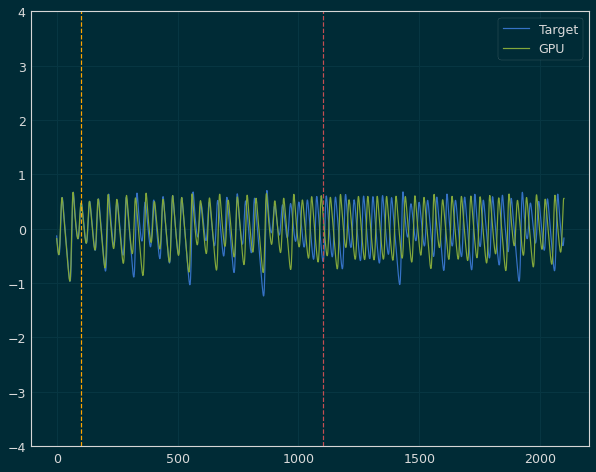

 Iter=43 a=0.419 sr=7.726 amp=0.154  ri=0.532 rr=2.039 loss=0.636044


Iter: 43 #### Diagnostic 0.636044   Time 14.41  Best 0.636 NRMSE 0.177 CD 0.459
Iter: 44 #### Diagnostic 1000.000000   Time 17.68  Best 0.636 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 15.79  Best 0.636 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 10.17  Best 0.636 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 17.95  Best 0.636 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 0.829808   Time 11.43  Best 0.636 NRMSE 0.202 CD 0.628
Iter: 49 #### Diagnostic 1000.000000   Time 16.45  Best 0.636 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 11.52  Best 0.636 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 14.49  Best 0.636 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 17.31  Best 0.636 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 17.42  Best 0.636 NRMSE 1000.000 CD nan
Iter: 54 ####

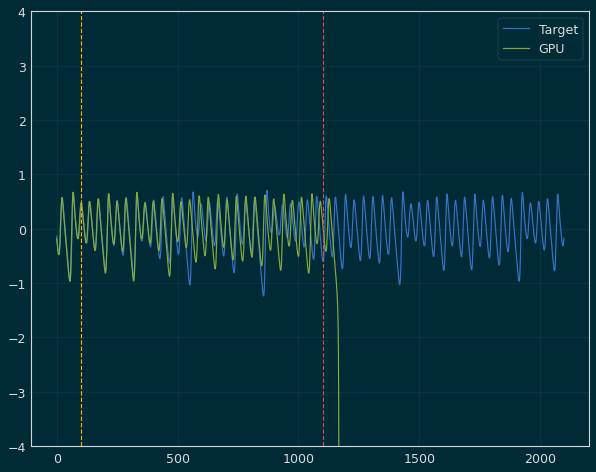

 Iter=10 a=0.087 sr=4.409 amp=0.286  ri=0.885 rr=3.294 loss=0.671123


Iter: 10 #### Diagnostic 0.671123   Time 17.49  Best 0.671 NRMSE 0.179 CD 0.492
Iter: 11 #### Diagnostic 1000.000000   Time 19.20  Best 0.671 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.863655   Time 13.28  Best 0.671 NRMSE 0.178 CD 0.685
Iter: 13 #### Diagnostic 1000.000000   Time 14.58  Best 0.671 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 14.71  Best 0.671 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 16.32  Best 0.671 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 13.49  Best 0.671 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.070665   Time 11.73  Best 0.671 NRMSE 0.184 CD 0.886
Iter: 18 #### Diagnostic 1000.000000   Time 11.82  Best 0.671 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 13.45  Best 0.671 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.999924   Time 17.74  Best 0.671 NRMSE 0.182 CD 0.818
Iter: 21 #### Diagnos

Iter: 6 #### Diagnostic 1000.000000   Time 16.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 14.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 18.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 15.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 13.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 15.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 16.79  Best 1000.000 NRMSE 1000.000 CD nan


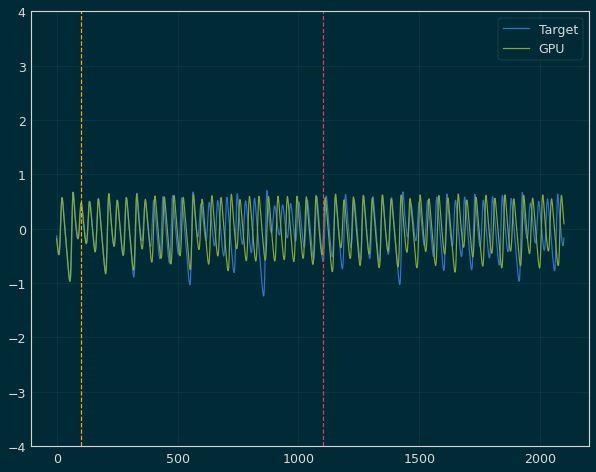

 Iter=13 a=0.143 sr=2.419 amp=0.807  ri=0.320 rr=0.107 loss=0.860623


Iter: 13 #### Diagnostic 0.860623   Time 15.43  Best 0.861 NRMSE 0.215 CD 0.646
Iter: 14 #### Diagnostic 1.071567   Time 15.80  Best 0.861 NRMSE 0.184 CD 0.888
Iter: 15 #### Diagnostic 1000.000000   Time 10.74  Best 0.861 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 0.963546   Time 12.61  Best 0.861 NRMSE 0.181 CD 0.782
Iter: 17 #### Diagnostic 1.543618   Time 16.41  Best 0.861 NRMSE 0.536 CD 1.008
Iter: 18 #### Diagnostic 1000.000000   Time 16.26  Best 0.861 NRMSE 29042676374811604.000 CD 0.991
Iter: 19 #### Diagnostic 1000.000000   Time 13.58  Best 0.861 NRMSE 1840068223454906979608166400.000 CD 1.006


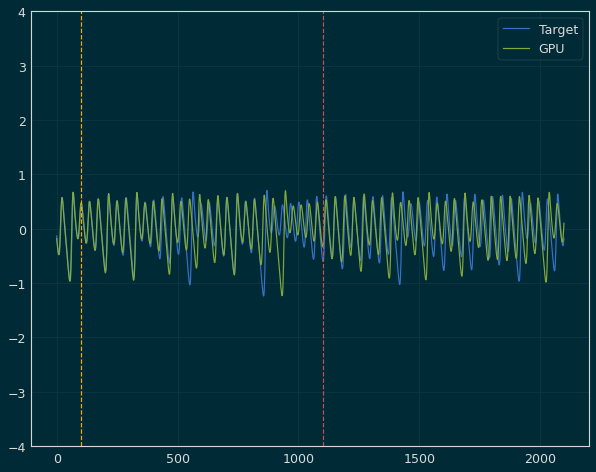

 Iter=20 a=0.234 sr=1.624 amp=0.958  ri=0.766 rr=0.942 loss=0.594528


Iter: 20 #### Diagnostic 0.594528   Time 16.82  Best 0.595 NRMSE 0.160 CD 0.435
Iter: 21 #### Diagnostic 1.008573   Time 19.33  Best 0.595 NRMSE 0.183 CD 0.826
Iter: 22 #### Diagnostic 1000.000000   Time 15.17  Best 0.595 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.241534   Time 17.16  Best 0.595 NRMSE 0.233 CD 1.008
Iter: 24 #### Diagnostic 0.678481   Time 9.29  Best 0.595 NRMSE 0.172 CD 0.506
Iter: 25 #### Diagnostic 1000.000000   Time 17.65  Best 0.595 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.655021   Time 19.21  Best 0.595 NRMSE 0.178 CD 0.477
Iter: 27 #### Diagnostic 1000.000000   Time 16.87  Best 0.595 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 15.43  Best 0.595 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.288022   Time 12.66  Best 0.595 NRMSE 0.238 CD 1.050
Iter: 30 #### Diagnostic 1000.000000   Time 12.32  Best 0.595 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.

Iter: 16 #### Diagnostic 1000.000000   Time 14.15  Best 1000.000 NRMSE 1000.000 CD nan


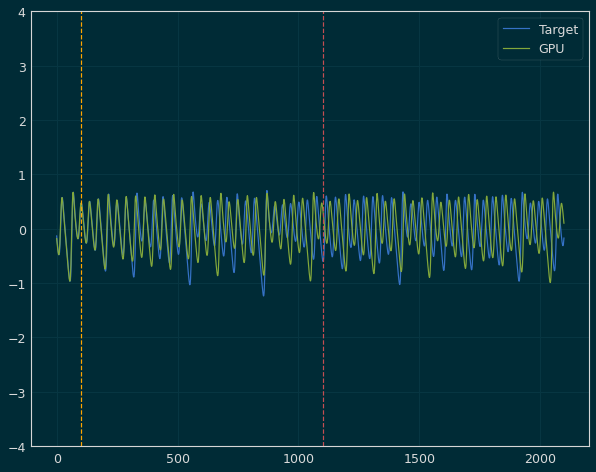

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.734165


Iter: 17 #### Diagnostic 0.734165   Time 14.41  Best 0.734 NRMSE 0.193 CD 0.541
Iter: 18 #### Diagnostic 0.963098   Time 12.53  Best 0.734 NRMSE 0.182 CD 0.781
Iter: 19 #### Diagnostic 1000.000000   Time 18.84  Best 0.734 NRMSE 1000.000 CD 0.997
Iter: 20 #### Diagnostic 1.162913   Time 10.19  Best 0.734 NRMSE 0.193 CD 0.970
Iter: 21 #### Diagnostic 1000.000000   Time 11.60  Best 0.734 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 14.95  Best 0.734 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 17.33  Best 0.734 NRMSE 1000.000 CD 1.000
Iter: 24 #### Diagnostic 1000.000000   Time 16.79  Best 0.734 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.538080   Time 11.37  Best 0.734 NRMSE 0.536 CD 1.002
Iter: 26 #### Diagnostic 1000.000000   Time 12.78  Best 0.734 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 13.70  Best 0.734 NRMSE 1000.000 CD nan
Iter: 28 #### Dia

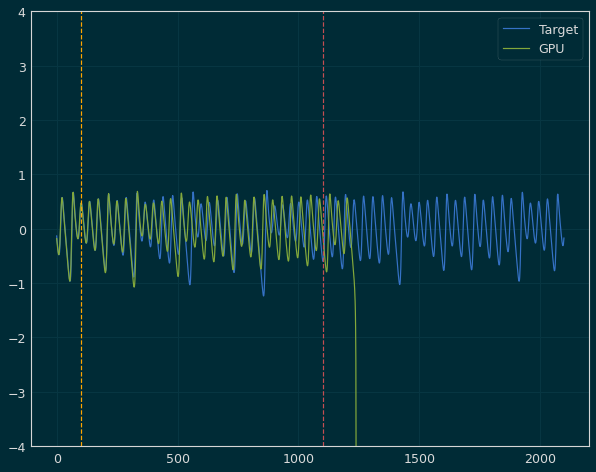

 Iter=44 a=0.580 sr=2.097 amp=0.690  ri=0.649 rr=4.377 loss=0.708877


Iter: 44 #### Diagnostic 0.708877   Time 16.18  Best 0.709 NRMSE 0.186 CD 0.523
Iter: 45 #### Diagnostic 1000.000000   Time 17.25  Best 0.709 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 17.53  Best 0.709 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 15.87  Best 0.709 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.011327   Time 16.29  Best 0.709 NRMSE 0.183 CD 0.829
Iter: 49 #### Diagnostic 0.979714   Time 13.38  Best 0.709 NRMSE 0.182 CD 0.797
Iter: 50 #### Diagnostic 1000.000000   Time 17.10  Best 0.709 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.542815   Time 14.48  Best 0.709 NRMSE 0.536 CD 1.007
Iter: 52 #### Diagnostic 1000.000000   Time 17.09  Best 0.709 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 17.84  Best 0.709 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 13.48  Best 0.709 NRMSE 1000.000 CD 0.926
Iter: 55 #### Diagn

Iter: 38 #### Diagnostic 1000.000000   Time 15.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.107854   Time 15.68  Best 1000.000 NRMSE 0.187 CD 0.921
Iter: 40 #### Diagnostic 1000.000000   Time 13.12  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 41 #### Diagnostic 1000.000000   Time 18.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 12.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 18.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.117830   Time 10.84  Best 1000.000 NRMSE 0.223 CD 0.894
Iter: 45 #### Diagnostic 1000.000000   Time 15.43  Best 1000.000 NRMSE 1000.000 CD nan


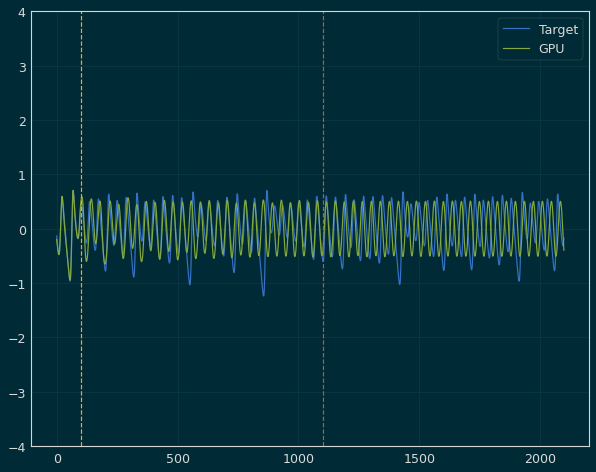

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.614033


Iter: 46 #### Diagnostic 0.614033   Time 12.97  Best 0.614 NRMSE 0.161 CD 0.453
Iter: 47 #### Diagnostic 1000.000000   Time 13.40  Best 0.614 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 18.40  Best 0.614 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.176150   Time 17.68  Best 0.614 NRMSE 0.187 CD 0.989
Iter: 50 #### Diagnostic 1.195778   Time 17.15  Best 0.614 NRMSE 0.213 CD 0.983
Iter: 51 #### Diagnostic 1.252528   Time 16.67  Best 0.614 NRMSE 0.195 CD 1.058
Iter: 52 #### Diagnostic 1.229604   Time 14.07  Best 0.614 NRMSE 0.331 CD 0.899
Iter: 53 #### Diagnostic 1000.000000   Time 13.78  Best 0.614 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 15.76  Best 0.614 NRMSE 1000.000 CD 1.073
Iter: 55 #### Diagnostic 1000.000000   Time 13.99  Best 0.614 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.543778   Time 15.10  Best 0.614 NRMSE 0.536 CD 1.008
Iter: 57 #### Diagnostic 10

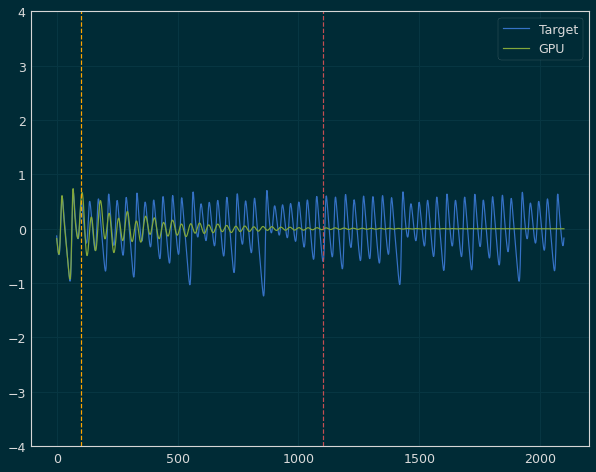

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.764135


Iter: 8 #### Diagnostic 0.764135   Time 14.06  Best 0.764 NRMSE 0.169 CD 0.596
Iter: 9 #### Diagnostic 1000.000000   Time 16.07  Best 0.764 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 14.45  Best 0.764 NRMSE 1000.000 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 14.40  Best 0.764 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 10.51  Best 0.764 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.023994   Time 12.34  Best 0.764 NRMSE 0.192 CD 0.832
Iter: 14 #### Diagnostic 1000.000000   Time 17.99  Best 0.764 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.050610   Time 10.45  Best 0.764 NRMSE 0.185 CD 0.865
Iter: 16 #### Diagnostic 1000.000000   Time 10.19  Best 0.764 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 13.27  Best 0.764 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 11.38  Best 0.764 NRMSE 1000.000 CD nan
Iter: 19 #### Diag

Iter: 4 #### Diagnostic 1000.000000   Time 14.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 12.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 12.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.188346   Time 14.41  Best 1000.000 NRMSE 0.202 CD 0.987
Iter: 8 #### Diagnostic 1000.000000   Time 16.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 8.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 15.52  Best 1000.000 NRMSE 1000.000 CD 1.005
Iter: 11 #### Diagnostic 1000.000000   Time 14.37  Best 1000.000 NRMSE 1000.000 CD nan


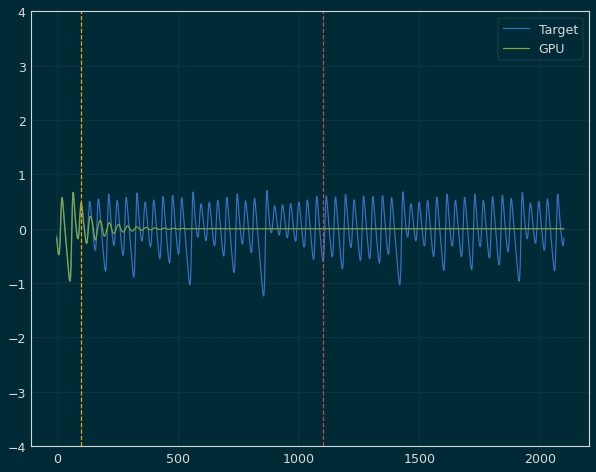

 Iter=12 a=0.615 sr=3.413 amp=0.193  ri=0.022 rr=4.454 loss=0.849343


Iter: 12 #### Diagnostic 0.849343   Time 16.93  Best 0.849 NRMSE 0.178 CD 0.672
Iter: 13 #### Diagnostic 1000.000000   Time 14.91  Best 0.849 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 15.19  Best 0.849 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 13.37  Best 0.849 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 12.26  Best 0.849 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.069026   Time 12.81  Best 0.849 NRMSE 0.184 CD 0.885
Iter: 18 #### Diagnostic 1000.000000   Time 12.33  Best 0.849 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 11.87  Best 0.849 NRMSE 1000.000 CD 1.064
Iter: 20 #### Diagnostic 0.992231   Time 16.98  Best 0.849 NRMSE 0.182 CD 0.810
Iter: 21 #### Diagnostic 1000.000000   Time 14.64  Best 0.849 NRMSE 1000.000 CD nan


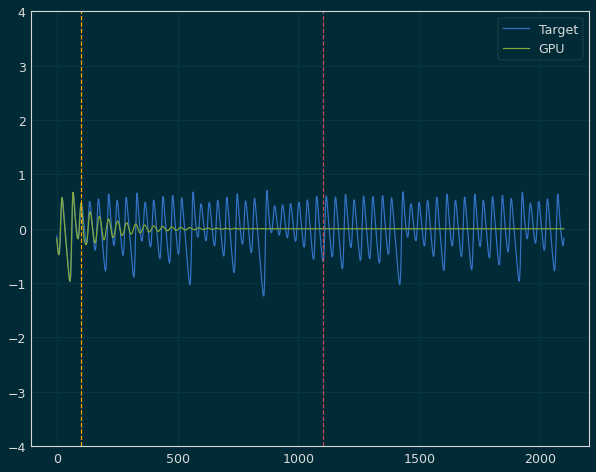

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.807723


Iter: 22 #### Diagnostic 0.807723   Time 13.69  Best 0.808 NRMSE 0.174 CD 0.633
Iter: 23 #### Diagnostic 1000.000000   Time 15.84  Best 0.808 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 15.12  Best 0.808 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 16.62  Best 0.808 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.535021   Time 8.86  Best 0.808 NRMSE 0.536 CD 0.999
Iter: 27 #### Diagnostic 1000.000000   Time 17.21  Best 0.808 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.357701   Time 7.18  Best 0.808 NRMSE 0.237 CD 1.120
Iter: 29 #### Diagnostic 1000.000000   Time 13.42  Best 0.808 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.546325   Time 11.40  Best 0.808 NRMSE 0.536 CD 1.011
Iter: 31 #### Diagnostic 1.117639   Time 11.25  Best 0.808 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.182017   Time 6.76  Best 0.808 NRMSE 0.195 CD 0.987
Iter: 33 #### Diagnostic 1000.00

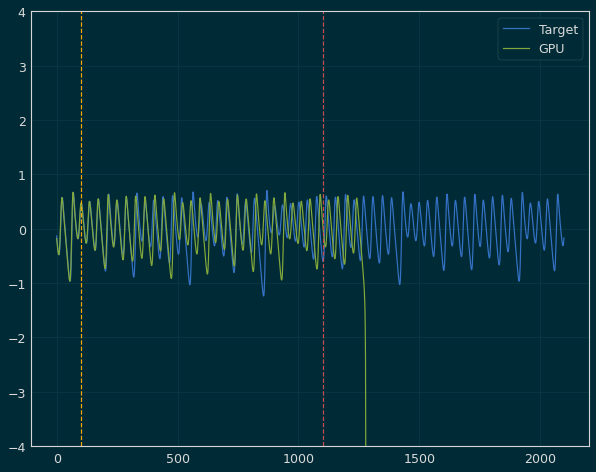

 Iter=61 a=0.458 sr=2.102 amp=0.657  ri=0.891 rr=4.684 loss=0.780422


Iter: 61 #### Diagnostic 0.780422   Time 16.00  Best 0.780 NRMSE 0.194 CD 0.587
Iter: 62 #### Diagnostic 1000.000000   Time 16.83  Best 0.780 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.196724   Time 20.00  Best 0.780 NRMSE 0.220 CD 0.977
Iter: 64 #### Diagnostic 1.543388   Time 11.39  Best 0.780 NRMSE 0.536 CD 1.008
Iter: 65 #### Diagnostic 1000.000000   Time 11.50  Best 0.780 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 11.81  Best 0.780 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 18.03  Best 0.780 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 14.62  Best 0.780 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 14.95  Best 0.780 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 18.17  Best 0.780 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.537421   Time 15.52  Best 0.780 NRMSE 0.536 CD 1.002
Iter: 72 #### Diagnos

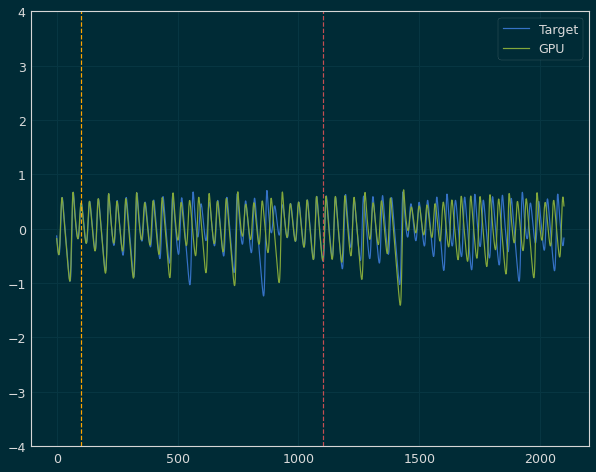

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.546157


Iter: 4 #### Diagnostic 0.546157   Time 14.99  Best 0.546 NRMSE 0.149 CD 0.397
Iter: 5 #### Diagnostic 1000.000000   Time 11.80  Best 0.546 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.535655   Time 18.13  Best 0.546 NRMSE 0.536 CD 1.000
Iter: 7 #### Diagnostic 1000.000000   Time 16.94  Best 0.546 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 15.40  Best 0.546 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 15.37  Best 0.546 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 11.15  Best 0.546 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.539245   Time 14.63  Best 0.546 NRMSE 0.536 CD 1.003
Iter: 12 #### Diagnostic 1000.000000   Time 13.22  Best 0.546 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 17.20  Best 0.546 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.070838   Time 16.78  Best 0.546 NRMSE 0.184 CD 0.887
Iter: 15 #### Diagnostic 100

Iter: 0 #### Diagnostic 1000.000000   Time 15.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 17.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.532606   Time 16.08  Best 1000.000 NRMSE 0.536 CD 0.997
Iter: 3 #### Diagnostic 1000.000000   Time 13.59  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 4 #### Diagnostic 1000.000000   Time 12.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.543599   Time 14.56  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 6 #### Diagnostic 1000.000000   Time 18.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 11.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 12.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.908104   Time 16.72  Best 1000.000 NRMSE 0.222 CD 0.686
Iter: 10 #### Diagnostic 1000.000000   Time 11.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 13.81  Best 1000.00

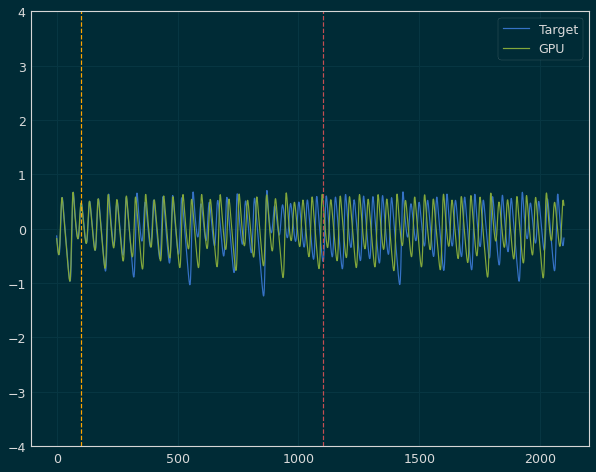

 Iter=15 a=0.555 sr=7.115 amp=0.184  ri=0.316 rr=0.371 loss=0.826318


Iter: 15 #### Diagnostic 0.826318   Time 15.10  Best 0.826 NRMSE 0.206 CD 0.620
Iter: 16 #### Diagnostic 1000.000000   Time 11.49  Best 0.826 NRMSE 1000.000 CD nan


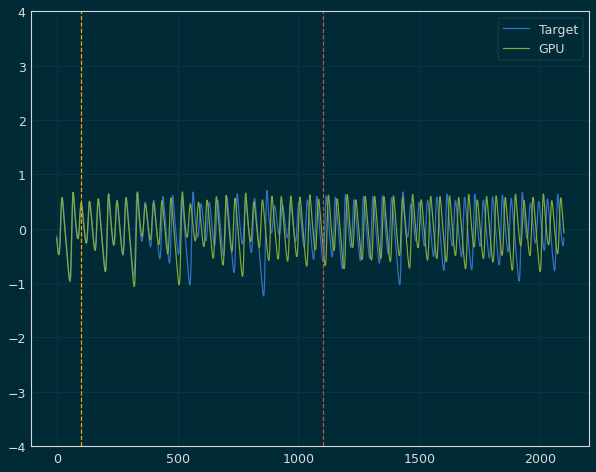

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.760361


Iter: 17 #### Diagnostic 0.760361   Time 13.27  Best 0.760 NRMSE 0.189 CD 0.571
Iter: 18 #### Diagnostic 0.954234   Time 15.83  Best 0.760 NRMSE 0.182 CD 0.773
Iter: 19 #### Diagnostic 1.541498   Time 14.86  Best 0.760 NRMSE 0.536 CD 1.006
Iter: 20 #### Diagnostic 1.121542   Time 11.93  Best 0.760 NRMSE 0.186 CD 0.935
Iter: 21 #### Diagnostic 1000.000000   Time 16.38  Best 0.760 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 12.15  Best 0.760 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 13.39  Best 0.760 NRMSE 1000.000 CD 1.082
Iter: 24 #### Diagnostic 1000.000000   Time 11.82  Best 0.760 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.544910   Time 10.94  Best 0.760 NRMSE 0.536 CD 1.009
Iter: 26 #### Diagnostic 0.901881   Time 17.08  Best 0.760 NRMSE 0.208 CD 0.694
Iter: 27 #### Diagnostic 1000.000000   Time 14.11  Best 0.760 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.

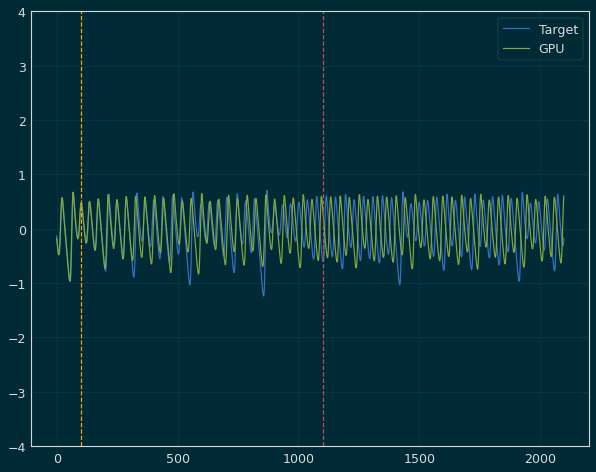

 Iter=69 a=0.107 sr=1.357 amp=0.951  ri=0.828 rr=4.343 loss=0.731631


Iter: 69 #### Diagnostic 0.731631   Time 13.68  Best 0.732 NRMSE 0.191 CD 0.541
Iter: 70 #### Diagnostic 1000.000000   Time 9.14  Best 0.732 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 10.91  Best 0.732 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 12.61  Best 0.732 NRMSE 1000.000 CD 1.001
Iter: 73 #### Diagnostic 1000.000000   Time 14.23  Best 0.732 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 9.88  Best 0.732 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 12.53  Best 0.732 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 13.47  Best 0.732 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.060264   Time 9.95  Best 0.732 NRMSE 0.184 CD 0.877
Iter: 78 #### Diagnostic 1.114965   Time 13.50  Best 0.732 NRMSE 0.193 CD 0.922
Iter: 79 #### Diagnostic 1000.000000   Time 10.79  Best 0.732 NRMSE 1000.000 CD nan
Iter: 80 #### Diag

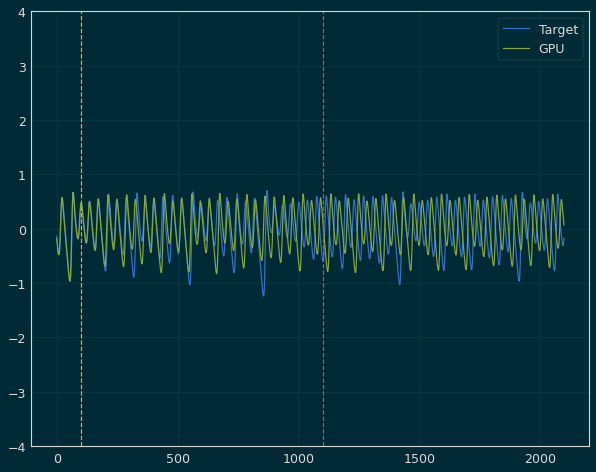

 Iter=21 a=0.201 sr=1.706 amp=0.786  ri=0.678 rr=1.170 loss=0.725496


Iter: 21 #### Diagnostic 0.725496   Time 17.58  Best 0.725 NRMSE 0.188 CD 0.538
Iter: 22 #### Diagnostic 1000.000000   Time 16.61  Best 0.725 NRMSE 3484192.217 CD 0.992
Iter: 23 #### Diagnostic 1000.000000   Time 12.85  Best 0.725 NRMSE 1219754.049 CD 1.002
Iter: 24 #### Diagnostic 1000.000000   Time 13.37  Best 0.725 NRMSE 4841681952629260308971520.000 CD 0.994
Iter: 25 #### Diagnostic 1000.000000   Time 10.30  Best 0.725 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 15.09  Best 0.725 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 17.65  Best 0.725 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 15.76  Best 0.725 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 12.44  Best 0.725 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 11.29  Best 0.725 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 17.00  Best 0.72

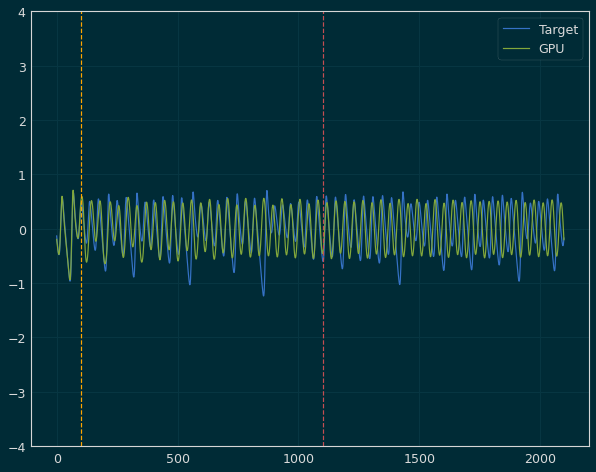

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.603682


Iter: 46 #### Diagnostic 0.603682   Time 11.25  Best 0.604 NRMSE 0.161 CD 0.442
Iter: 47 #### Diagnostic 1000.000000   Time 13.55  Best 0.604 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 11.01  Best 0.604 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.171097   Time 17.21  Best 0.604 NRMSE 0.187 CD 0.984
Iter: 50 #### Diagnostic 1.093237   Time 13.85  Best 0.604 NRMSE 0.207 CD 0.887
Iter: 51 #### Diagnostic 1.244012   Time 8.48  Best 0.604 NRMSE 0.193 CD 1.051
Iter: 52 #### Diagnostic 1.291955   Time 16.72  Best 0.604 NRMSE 0.341 CD 0.951
Iter: 53 #### Diagnostic 1000.000000   Time 17.21  Best 0.604 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 12.65  Best 0.604 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 18.48  Best 0.604 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 16.60  Best 0.604 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1

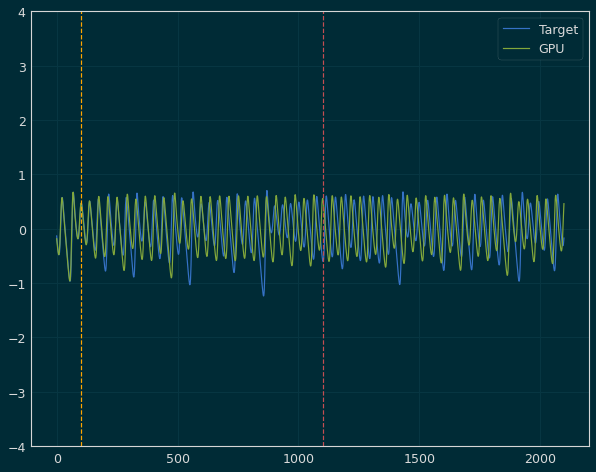

 Iter=0 a=0.069 sr=5.318 amp=0.195  ri=0.926 rr=0.527 loss=0.862929


Iter: 0 #### Diagnostic 0.862929   Time 17.96  Best 0.863 NRMSE 0.212 CD 0.651
Iter: 1 #### Diagnostic 1000.000000   Time 16.27  Best 0.863 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 12.63  Best 0.863 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 13.36  Best 0.863 NRMSE 1000.000 CD 1.000
Iter: 4 #### Diagnostic 1.025202   Time 14.79  Best 0.863 NRMSE 0.183 CD 0.842
Iter: 5 #### Diagnostic 1.592908   Time 14.62  Best 0.863 NRMSE 0.536 CD 1.057
Iter: 6 #### Diagnostic 1000.000000   Time 16.42  Best 0.863 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 13.74  Best 0.863 NRMSE 1000.000 CD nan


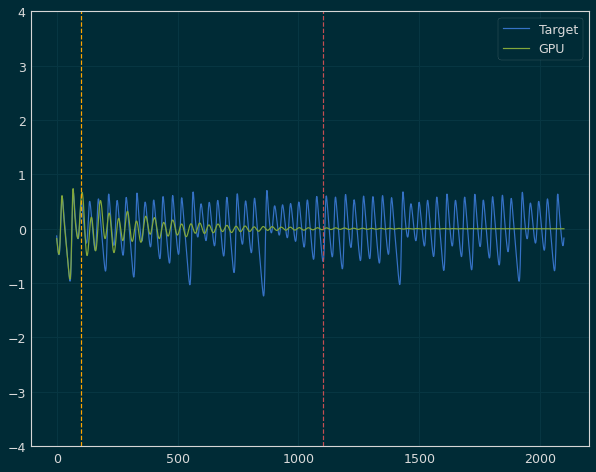

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.752506


Iter: 8 #### Diagnostic 0.752506   Time 14.15  Best 0.753 NRMSE 0.168 CD 0.585
Iter: 9 #### Diagnostic 1000.000000   Time 11.63  Best 0.753 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 11.65  Best 0.753 NRMSE 1000.000 CD 1.008
Iter: 11 #### Diagnostic 1000.000000   Time 9.41  Best 0.753 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 17.06  Best 0.753 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.023503   Time 9.47  Best 0.753 NRMSE 0.191 CD 0.832
Iter: 14 #### Diagnostic 1000.000000   Time 13.62  Best 0.753 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.054334   Time 11.26  Best 0.753 NRMSE 0.185 CD 0.869
Iter: 16 #### Diagnostic 1000.000000   Time 16.03  Best 0.753 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 15.00  Best 0.753 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 13.65  Best 0.753 NRMSE 1000.000 CD nan
Iter: 19 #### Diagno

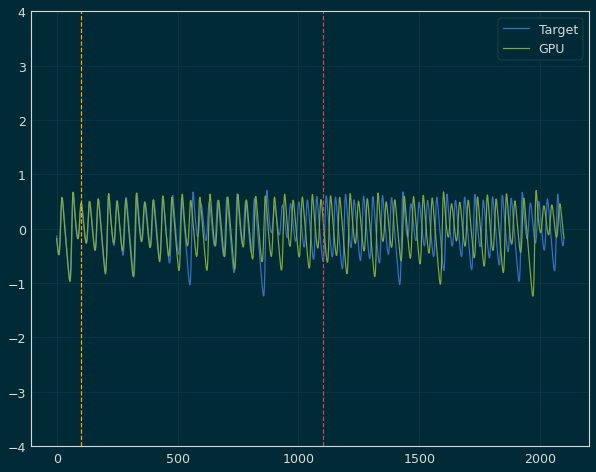

 Iter=36 a=0.713 sr=4.980 amp=0.240  ri=0.691 rr=1.424 loss=0.661450


Iter: 36 #### Diagnostic 0.661450   Time 17.55  Best 0.661 NRMSE 0.179 CD 0.482
Iter: 37 #### Diagnostic 1000.000000   Time 14.57  Best 0.661 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 16.94  Best 0.661 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.129721   Time 14.50  Best 0.661 NRMSE 0.172 CD 0.958
Iter: 40 #### Diagnostic 1.054460   Time 13.27  Best 0.661 NRMSE 0.184 CD 0.871
Iter: 41 #### Diagnostic 1.118573   Time 11.27  Best 0.661 NRMSE 0.185 CD 0.933
Iter: 42 #### Diagnostic 1.109566   Time 14.28  Best 0.661 NRMSE 0.185 CD 0.925
Iter: 43 #### Diagnostic 0.769301   Time 17.99  Best 0.661 NRMSE 0.189 CD 0.580
Iter: 44 #### Diagnostic 1000.000000   Time 15.89  Best 0.661 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 11.44  Best 0.661 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 9.72  Best 0.661 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.

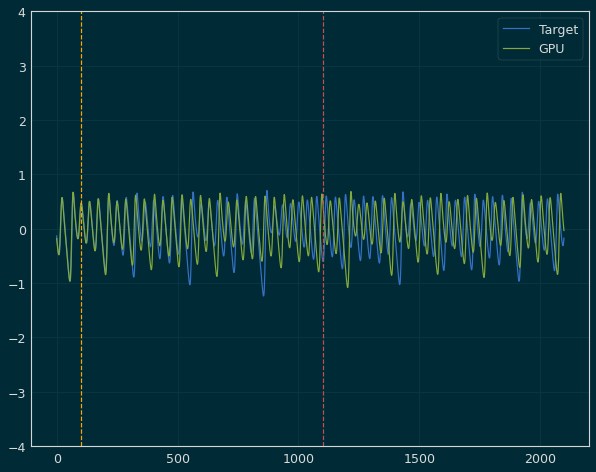

 Iter=10 a=0.087 sr=4.409 amp=0.286  ri=0.885 rr=3.294 loss=0.776210


Iter: 10 #### Diagnostic 0.776210   Time 13.72  Best 0.776 NRMSE 0.194 CD 0.582
Iter: 11 #### Diagnostic 1000.000000   Time 9.67  Best 0.776 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.852862   Time 14.92  Best 0.776 NRMSE 0.178 CD 0.675
Iter: 13 #### Diagnostic 1000.000000   Time 10.19  Best 0.776 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 10.09  Best 0.776 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 13.90  Best 0.776 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 12.93  Best 0.776 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.069551   Time 14.92  Best 0.776 NRMSE 0.184 CD 0.885
Iter: 18 #### Diagnostic 1000.000000   Time 12.42  Best 0.776 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 11.89  Best 0.776 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.995112   Time 15.39  Best 0.776 NRMSE 0.182 CD 0.813
Iter: 21 #### Diagnost

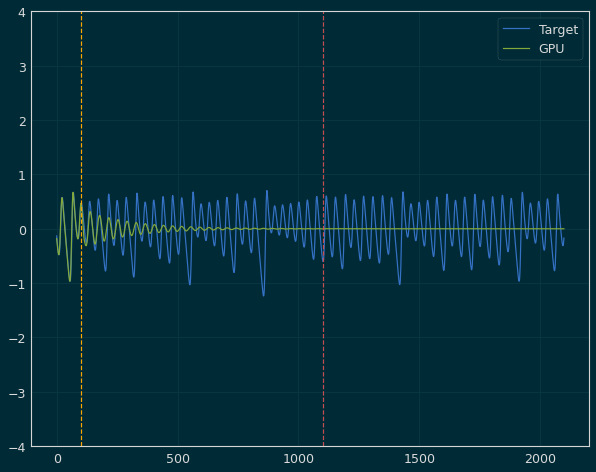

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.723745


Iter: 22 #### Diagnostic 0.723745   Time 10.69  Best 0.724 NRMSE 0.170 CD 0.554
Iter: 23 #### Diagnostic 1000.000000   Time 9.99  Best 0.724 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 16.34  Best 0.724 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 16.06  Best 0.724 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 14.50  Best 0.724 NRMSE 1000.000 CD 0.999
Iter: 27 #### Diagnostic 1000.000000   Time 14.12  Best 0.724 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.252551   Time 12.96  Best 0.724 NRMSE 0.231 CD 1.022
Iter: 29 #### Diagnostic 1000.000000   Time 14.33  Best 0.724 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 14.77  Best 0.724 NRMSE 1000.000 CD 0.992
Iter: 31 #### Diagnostic 1.117514   Time 8.85  Best 0.724 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.196892   Time 8.73  Best 0.724 NRMSE 0.195 CD 1.002
Iter: 33 #### Diagno

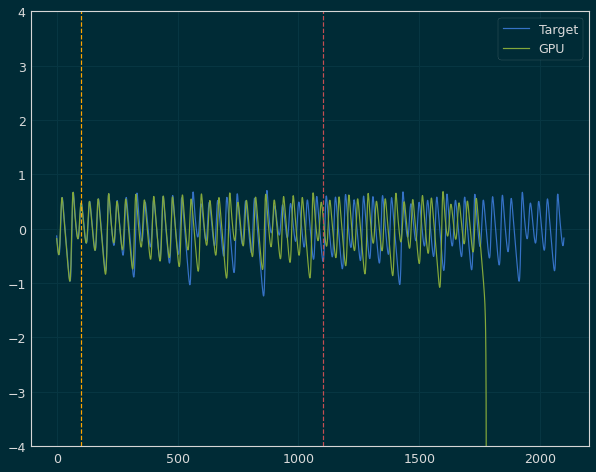

 Iter=98 a=0.515 sr=7.864 amp=0.185  ri=0.612 rr=2.905 loss=0.704819


Iter: 98 #### Diagnostic 0.704819   Time 15.17  Best 0.705 NRMSE 0.185 CD 0.520
Iter: 99 #### Diagnostic 1000.000000   Time 11.07  Best 0.705 NRMSE 1000.000 CD nan

Best result = 0.7048191737471677
a = 0.5152334579154145
sr = 7.863670612092308
amp = 0.18453003659579334
ri = 0.6123976126380598
rr = 2.9052400059584182
********** Size 900 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.199272   Time 14.96  Best 1000.000 NRMSE 0.229 CD 0.970
Iter: 1 #### Diagnostic 1.259429   Time 15.49  Best 1000.000 NRMSE 0.196 CD 1.064
Iter: 2 #### Diagnostic 1000.000000   Time 16.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 15.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 17.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 12.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 14.70  Best 1000.00

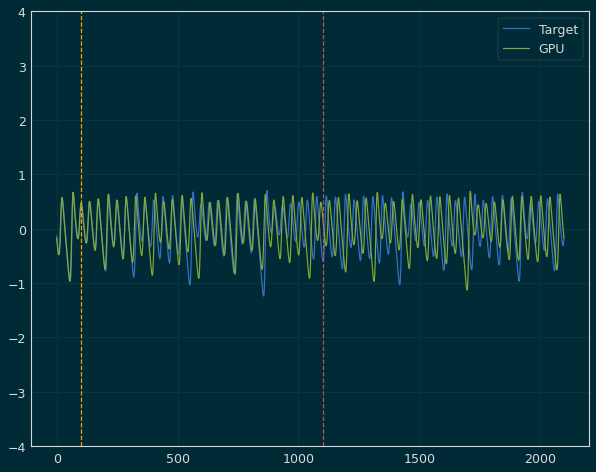

 Iter=34 a=0.720 sr=4.820 amp=0.232  ri=0.444 rr=3.216 loss=0.683429


Iter: 34 #### Diagnostic 0.683429   Time 10.61  Best 0.683 NRMSE 0.181 CD 0.502
Iter: 35 #### Diagnostic 1000.000000   Time 14.50  Best 0.683 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 15.12  Best 0.683 NRMSE 1000.000 CD 0.999
Iter: 37 #### Diagnostic 1.112115   Time 12.63  Best 0.683 NRMSE 0.189 CD 0.923
Iter: 38 #### Diagnostic 1000.000000   Time 9.99  Best 0.683 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 12.80  Best 0.683 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.056154   Time 15.30  Best 0.683 NRMSE 0.184 CD 0.873
Iter: 41 #### Diagnostic 1000.000000   Time 12.34  Best 0.683 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 14.21  Best 0.683 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.282296   Time 16.71  Best 0.683 NRMSE 0.206 CD 1.076
Iter: 44 #### Diagnostic 1000.000000   Time 13.79  Best 0.683 NRMSE 1000.000 CD nan
Iter: 45 #### Diagno

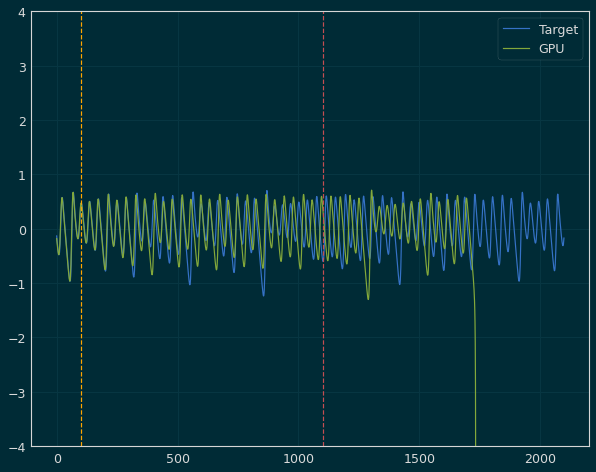

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.735983


Iter: 9 #### Diagnostic 0.735983   Time 12.37  Best 0.736 NRMSE 0.191 CD 0.545
Iter: 10 #### Diagnostic 1000.000000   Time 9.94  Best 0.736 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 11.95  Best 0.736 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 14.88  Best 0.736 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 14.17  Best 0.736 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 14.16  Best 0.736 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 17.48  Best 0.736 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 15.07  Best 0.736 NRMSE 1000.000 CD nan


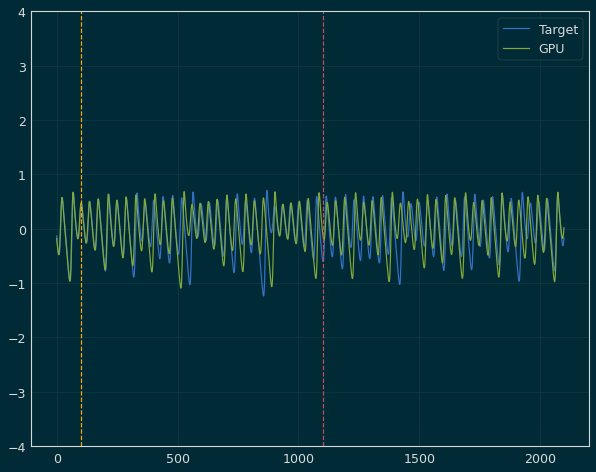

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.668982


Iter: 17 #### Diagnostic 0.668982   Time 13.47  Best 0.669 NRMSE 0.168 CD 0.501
Iter: 18 #### Diagnostic 0.956485   Time 15.62  Best 0.669 NRMSE 0.182 CD 0.775
Iter: 19 #### Diagnostic 1000.000000   Time 12.90  Best 0.669 NRMSE 1000.000 CD 0.998
Iter: 20 #### Diagnostic 1.131673   Time 10.16  Best 0.669 NRMSE 0.188 CD 0.944
Iter: 21 #### Diagnostic 1000.000000   Time 14.06  Best 0.669 NRMSE 1000.000 CD nan


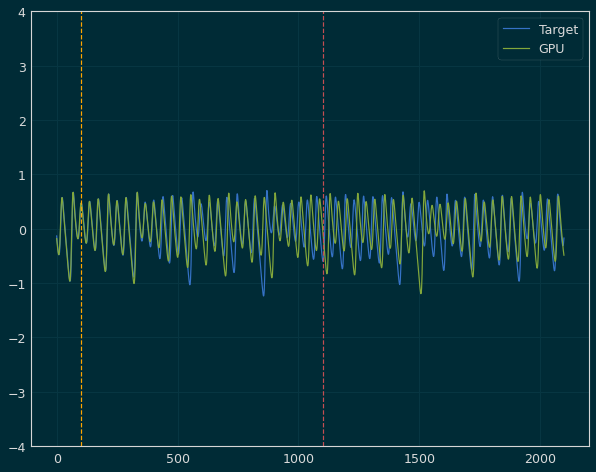

 Iter=22 a=0.356 sr=4.942 amp=0.320  ri=0.636 rr=1.647 loss=0.661454


Iter: 22 #### Diagnostic 0.661454   Time 16.32  Best 0.661 NRMSE 0.176 CD 0.486
Iter: 23 #### Diagnostic 1000.000000   Time 13.93  Best 0.661 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 8.57  Best 0.661 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.98  Best 0.661 NRMSE 1000.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 13.41  Best 0.661 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 13.59  Best 0.661 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 14.01  Best 0.661 NRMSE 1000.000 CD 1.051
Iter: 29 #### Diagnostic 0.818635   Time 10.74  Best 0.661 NRMSE 0.176 CD 0.642
Iter: 30 #### Diagnostic 1000.000000   Time 11.24  Best 0.661 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 16.24  Best 0.661 NRMSE 1000.000 CD 0.991
Iter: 32 #### Diagnostic 1000.000000   Time 14.89  Best 0.661 NRMSE 1000.000 CD nan
Iter: 33 

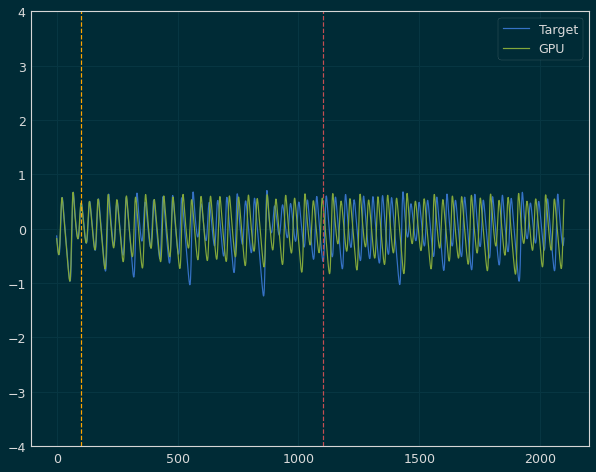

 Iter=7 a=0.311 sr=1.937 amp=0.811  ri=0.970 rr=3.990 loss=0.818681


Iter: 7 #### Diagnostic 0.818681   Time 11.29  Best 0.819 NRMSE 0.205 CD 0.613
Iter: 8 #### Diagnostic 0.980064   Time 14.96  Best 0.819 NRMSE 0.181 CD 0.799
Iter: 9 #### Diagnostic 1000.000000   Time 11.01  Best 0.819 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 11.05  Best 0.819 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 15.50  Best 0.819 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 15.27  Best 0.819 NRMSE 1000.000 CD 0.991
Iter: 13 #### Diagnostic 1.535801   Time 17.82  Best 0.819 NRMSE 0.536 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 16.02  Best 0.819 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 16.68  Best 0.819 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 16.35  Best 0.819 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 8.98  Best 0.819 NRMSE 1000.000 CD nan
Iter: 18 #### Diagno

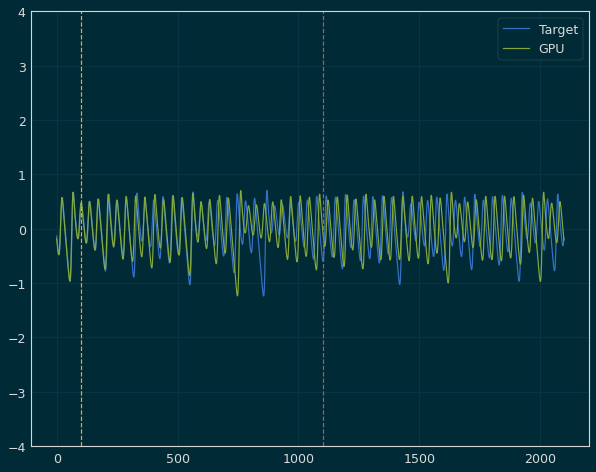

 Iter=22 a=0.795 sr=4.888 amp=0.469  ri=0.888 rr=0.607 loss=0.704015


Iter: 22 #### Diagnostic 0.704015   Time 16.69  Best 0.704 NRMSE 0.182 CD 0.522
Iter: 23 #### Diagnostic 1000.000000   Time 8.93  Best 0.704 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 16.64  Best 0.704 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 12.47  Best 0.704 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 16.50  Best 0.704 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.542653   Time 15.79  Best 0.704 NRMSE 0.536 CD 1.007
Iter: 28 #### Diagnostic 1000.000000   Time 12.97  Best 0.704 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 8.69  Best 0.704 NRMSE 1000.000 CD 0.993
Iter: 30 #### Diagnostic 1000.000000   Time 12.34  Best 0.704 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.721060   Time 10.20  Best 0.704 NRMSE 0.189 CD 0.532
Iter: 32 #### Diagnostic 1000.000000   Time 10.17  Best 0.704 NRMSE 1000.000 CD nan
Iter: 33 #### Dia

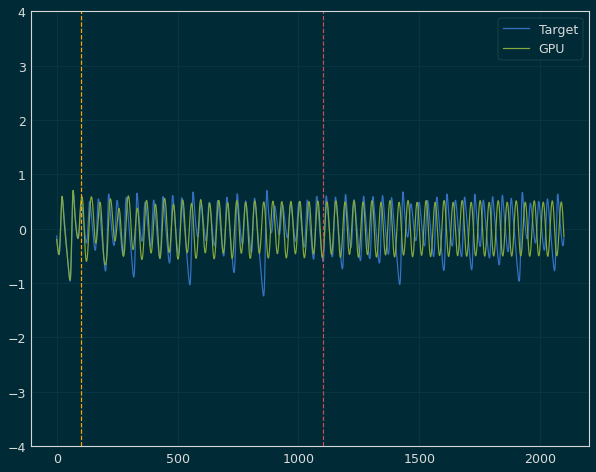

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.591043


Iter: 46 #### Diagnostic 0.591043   Time 12.65  Best 0.591 NRMSE 0.161 CD 0.431
Iter: 47 #### Diagnostic 1000.000000   Time 8.94  Best 0.591 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 12.24  Best 0.591 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.173530   Time 11.97  Best 0.591 NRMSE 0.187 CD 0.987
Iter: 50 #### Diagnostic 1.125191   Time 11.97  Best 0.591 NRMSE 0.209 CD 0.916
Iter: 51 #### Diagnostic 1.236931   Time 13.44  Best 0.591 NRMSE 0.193 CD 1.044
Iter: 52 #### Diagnostic 1.214897   Time 11.73  Best 0.591 NRMSE 0.324 CD 0.891
Iter: 53 #### Diagnostic 1000.000000   Time 15.21  Best 0.591 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.537989   Time 13.43  Best 0.591 NRMSE 0.536 CD 1.002
Iter: 55 #### Diagnostic 1000.000000   Time 14.11  Best 0.591 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 15.73  Best 0.591 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.

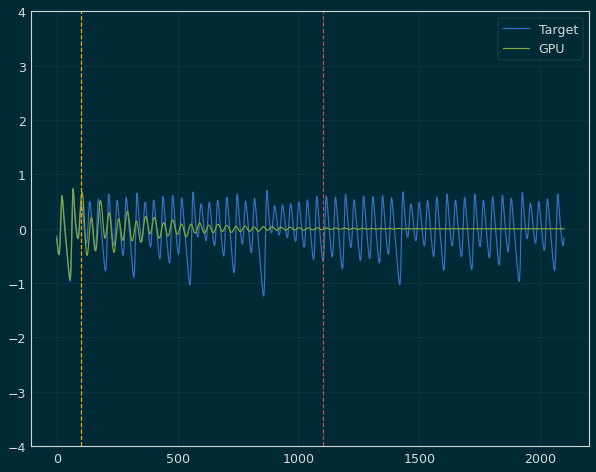

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.761895


Iter: 8 #### Diagnostic 0.761895   Time 16.23  Best 0.762 NRMSE 0.168 CD 0.593
Iter: 9 #### Diagnostic 1000.000000   Time 14.78  Best 0.762 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.534617   Time 13.87  Best 0.762 NRMSE 0.536 CD 0.999
Iter: 11 #### Diagnostic 1000.000000   Time 11.82  Best 0.762 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 9.45  Best 0.762 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.030599   Time 16.76  Best 0.762 NRMSE 0.192 CD 0.839
Iter: 14 #### Diagnostic 1000.000000   Time 12.75  Best 0.762 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.041164   Time 10.21  Best 0.762 NRMSE 0.184 CD 0.857
Iter: 16 #### Diagnostic 1000.000000   Time 12.16  Best 0.762 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 13.45  Best 0.762 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 15.90  Best 0.762 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 

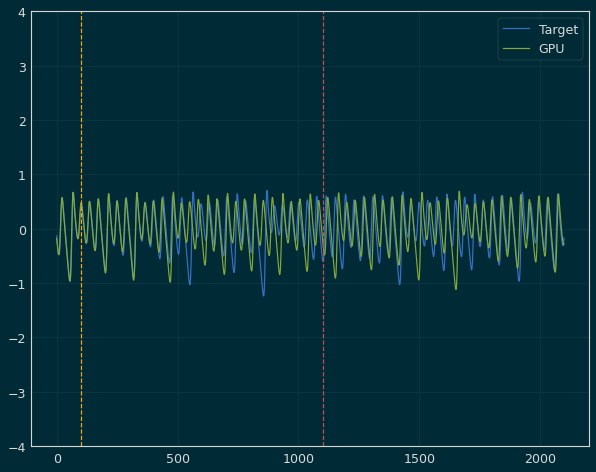

 Iter=31 a=0.408 sr=2.142 amp=0.745  ri=0.686 rr=2.119 loss=0.686449


Iter: 31 #### Diagnostic 0.686449   Time 15.55  Best 0.686 NRMSE 0.176 CD 0.511
Iter: 32 #### Diagnostic 1.101502   Time 14.88  Best 0.686 NRMSE 0.187 CD 0.915
Iter: 33 #### Diagnostic 1000.000000   Time 12.51  Best 0.686 NRMSE 1000.000 CD 0.992
Iter: 34 #### Diagnostic 1000.000000   Time 9.69  Best 0.686 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 11.43  Best 0.686 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 13.44  Best 0.686 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 11.10  Best 0.686 NRMSE 249950662708433212407808.000 CD 0.996
Iter: 38 #### Diagnostic 1000.000000   Time 9.87  Best 0.686 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.317718   Time 11.80  Best 0.686 NRMSE 0.271 CD 1.047
Iter: 40 #### Diagnostic 1.065916   Time 14.40  Best 0.686 NRMSE 0.184 CD 0.882
Iter: 41 #### Diagnostic 1.112272   Time 15.64  Best 0.686 NRMSE 0.185 CD 0.927
Ite

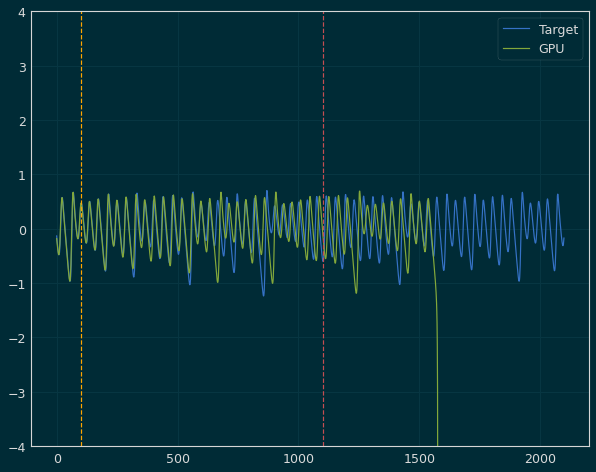

 Iter=88 a=0.389 sr=1.937 amp=0.739  ri=0.378 rr=1.124 loss=0.631090


Iter: 88 #### Diagnostic 0.631090   Time 15.46  Best 0.631 NRMSE 0.170 CD 0.461
Iter: 89 #### Diagnostic 1000.000000   Time 16.01  Best 0.631 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 12.04  Best 0.631 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 10.57  Best 0.631 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 16.24  Best 0.631 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.023407   Time 10.96  Best 0.631 NRMSE 0.183 CD 0.841
Iter: 94 #### Diagnostic 1.108143   Time 9.25  Best 0.631 NRMSE 0.185 CD 0.923
Iter: 95 #### Diagnostic 1000.000000   Time 13.11  Best 0.631 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 13.74  Best 0.631 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 11.48  Best 0.631 NRMSE 1000.000 CD 0.996
Iter: 98 #### Diagnostic 1.089201   Time 12.72  Best 0.631 NRMSE 0.185 CD 0.905
Iter: 99 #### Diagno

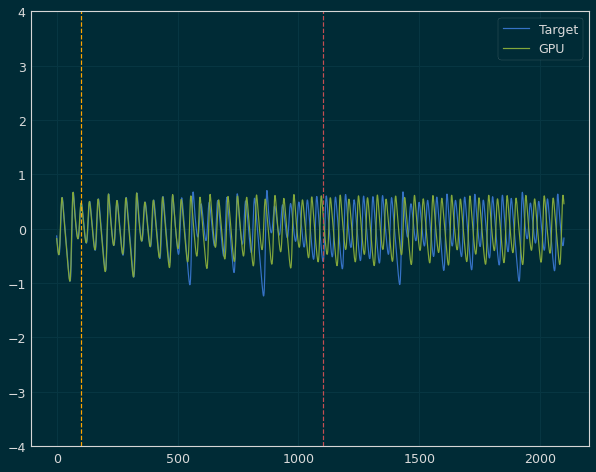

 Iter=4 a=0.240 sr=6.874 amp=0.203  ri=0.727 rr=1.822 loss=0.691330


Iter: 4 #### Diagnostic 0.691330   Time 16.17  Best 0.691 NRMSE 0.183 CD 0.508
Iter: 5 #### Diagnostic 1000.000000   Time 17.36  Best 0.691 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 13.99  Best 0.691 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.257902   Time 16.24  Best 0.691 NRMSE 0.214 CD 1.044
Iter: 8 #### Diagnostic 1000.000000   Time 11.32  Best 0.691 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 10.26  Best 0.691 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.716143   Time 16.02  Best 0.691 NRMSE 0.175 CD 0.541
Iter: 11 #### Diagnostic 1000.000000   Time 16.98  Best 0.691 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.862575   Time 15.92  Best 0.691 NRMSE 0.178 CD 0.684
Iter: 13 #### Diagnostic 1000.000000   Time 15.07  Best 0.691 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 13.70  Best 0.691 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 100

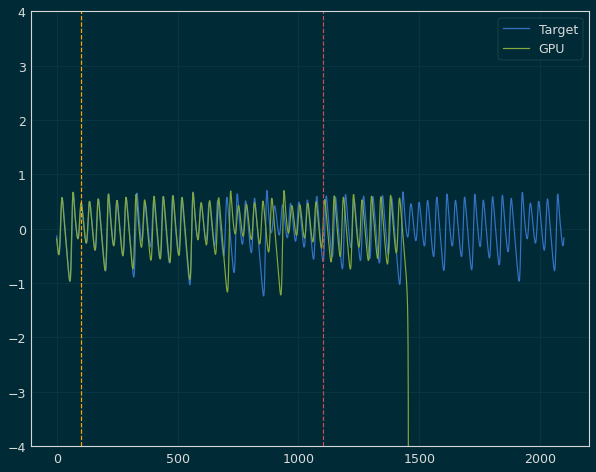

 Iter=61 a=0.458 sr=2.102 amp=0.657  ri=0.891 rr=4.684 loss=0.618655


Iter: 61 #### Diagnostic 0.618655   Time 11.91  Best 0.619 NRMSE 0.159 CD 0.460


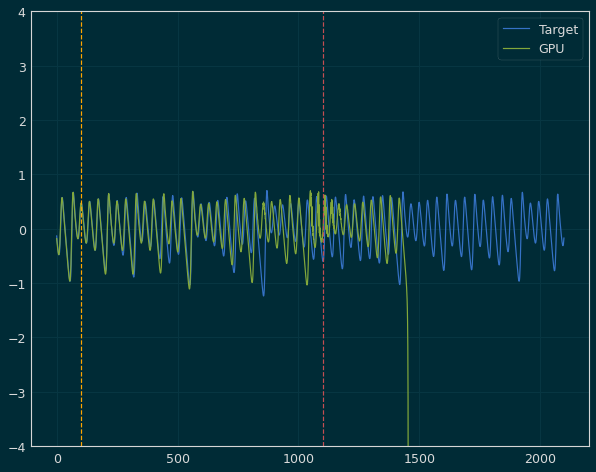

 Iter=62 a=0.706 sr=5.607 amp=0.238  ri=0.418 rr=0.894 loss=0.577519


Iter: 62 #### Diagnostic 0.577519   Time 15.55  Best 0.578 NRMSE 0.162 CD 0.415
Iter: 63 #### Diagnostic 1.196781   Time 11.46  Best 0.578 NRMSE 0.219 CD 0.978
Iter: 64 #### Diagnostic 1.541225   Time 14.77  Best 0.578 NRMSE 0.536 CD 1.005
Iter: 65 #### Diagnostic 1000.000000   Time 14.08  Best 0.578 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 11.42  Best 0.578 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 14.29  Best 0.578 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 12.17  Best 0.578 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 14.53  Best 0.578 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 14.08  Best 0.578 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.518287   Time 14.56  Best 0.578 NRMSE 0.508 CD 1.011
Iter: 72 #### Diagnostic 1000.000000   Time 14.51  Best 0.578 NRMSE 2020110585.171 CD 1.011
Iter: 73 ####

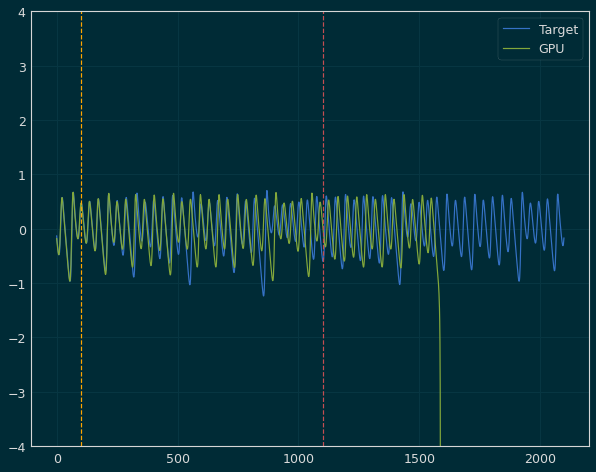

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.721210


Iter: 4 #### Diagnostic 0.721210   Time 13.91  Best 0.721 NRMSE 0.184 CD 0.537
Iter: 5 #### Diagnostic 1.527994   Time 9.31  Best 0.721 NRMSE 0.531 CD 0.997
Iter: 6 #### Diagnostic 1.533529   Time 17.67  Best 0.721 NRMSE 0.536 CD 0.998
Iter: 7 #### Diagnostic 1000.000000   Time 13.27  Best 0.721 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 15.46  Best 0.721 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 10.00  Best 0.721 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 10.89  Best 0.721 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 12.97  Best 0.721 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 14.27  Best 0.721 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 12.92  Best 0.721 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.075993   Time 11.78  Best 0.721 NRMSE 0.184 CD 0.892
Iter: 15 #### Diagnostic 1000

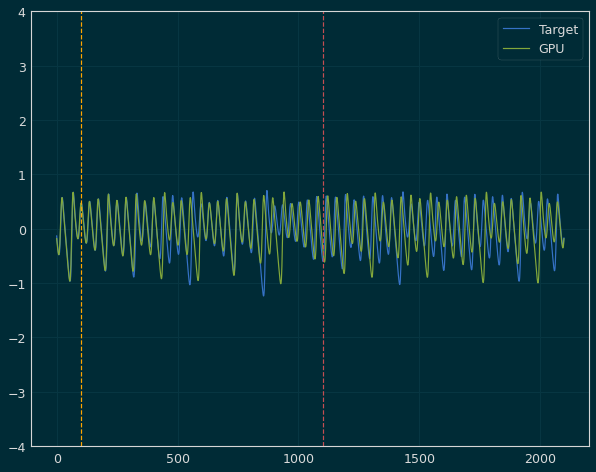

 Iter=34 a=0.720 sr=4.820 amp=0.232  ri=0.444 rr=3.216 loss=0.589693


Iter: 34 #### Diagnostic 0.589693   Time 15.19  Best 0.590 NRMSE 0.159 CD 0.431
Iter: 35 #### Diagnostic 1000.000000   Time 13.53  Best 0.590 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 12.41  Best 0.590 NRMSE 1000.000 CD 0.990
Iter: 37 #### Diagnostic 1.116506   Time 8.92  Best 0.590 NRMSE 0.190 CD 0.927
Iter: 38 #### Diagnostic 1000.000000   Time 12.26  Best 0.590 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 14.87  Best 0.590 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.060114   Time 9.01  Best 0.590 NRMSE 0.184 CD 0.876
Iter: 41 #### Diagnostic 1000.000000   Time 9.29  Best 0.590 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.544816   Time 10.21  Best 0.590 NRMSE 0.536 CD 1.009
Iter: 43 #### Diagnostic 1.275153   Time 15.05  Best 0.590 NRMSE 0.203 CD 1.072
Iter: 44 #### Diagnostic 1000.000000   Time 11.92  Best 0.590 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1

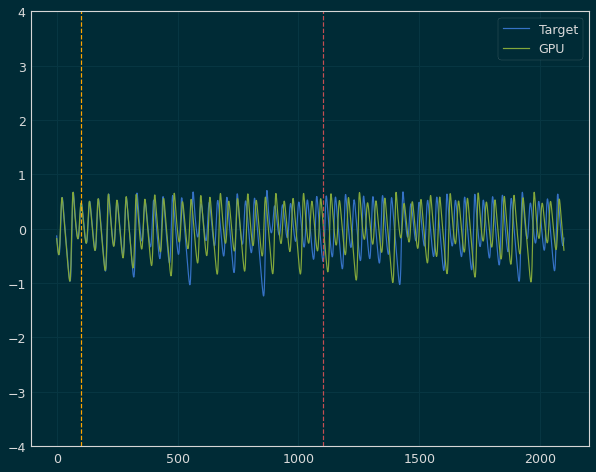

 Iter=15 a=0.555 sr=7.115 amp=0.184  ri=0.316 rr=0.371 loss=0.825980


Iter: 15 #### Diagnostic 0.825980   Time 15.93  Best 0.826 NRMSE 0.203 CD 0.623
Iter: 16 #### Diagnostic 1000.000000   Time 13.81  Best 0.826 NRMSE 1000.000 CD nan


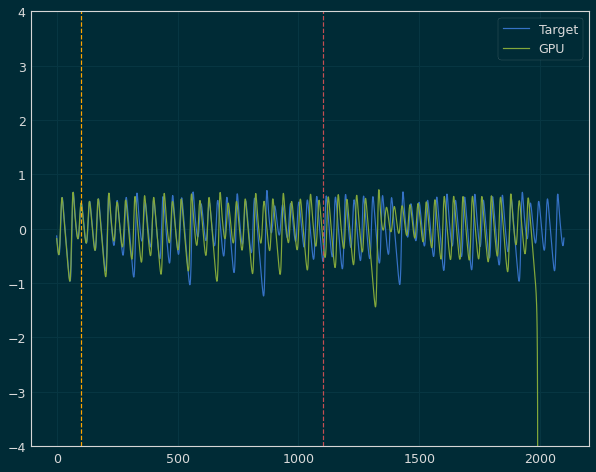

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.738697


Iter: 17 #### Diagnostic 0.738697   Time 12.63  Best 0.739 NRMSE 0.185 CD 0.554
Iter: 18 #### Diagnostic 0.953518   Time 9.15  Best 0.739 NRMSE 0.181 CD 0.772
Iter: 19 #### Diagnostic 1.540045   Time 16.69  Best 0.739 NRMSE 0.536 CD 1.004
Iter: 20 #### Diagnostic 1.167169   Time 14.15  Best 0.739 NRMSE 0.195 CD 0.972
Iter: 21 #### Diagnostic 1000.000000   Time 11.15  Best 0.739 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.829393   Time 11.12  Best 0.739 NRMSE 0.198 CD 0.631
Iter: 23 #### Diagnostic 1000.000000   Time 12.95  Best 0.739 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 8.94  Best 0.739 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 9.67  Best 0.739 NRMSE 1000.000 CD 0.993
Iter: 26 #### Diagnostic 0.923260   Time 7.83  Best 0.739 NRMSE 0.217 CD 0.707
Iter: 27 #### Diagnostic 1000.000000   Time 10.87  Best 0.739 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.5376

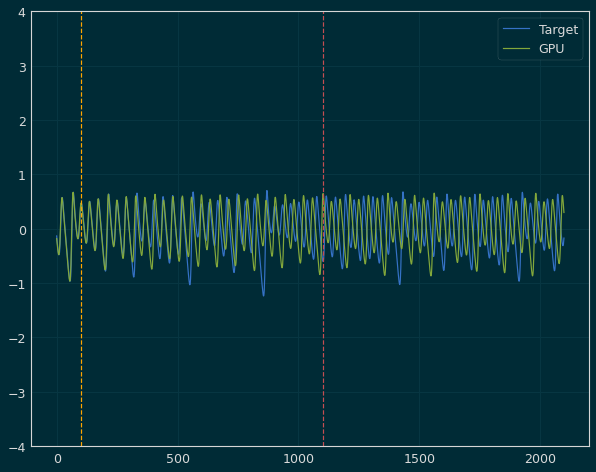

 Iter=3 a=0.527 sr=4.150 amp=0.657  ri=0.606 rr=0.196 loss=0.839007


Iter: 3 #### Diagnostic 0.839007   Time 8.29  Best 0.839 NRMSE 0.205 CD 0.634
Iter: 4 #### Diagnostic 1000.000000   Time 10.16  Best 0.839 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 10.03  Best 0.839 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 7.07  Best 0.839 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 8.29  Best 0.839 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.957961   Time 7.87  Best 0.839 NRMSE 0.181 CD 0.777
Iter: 9 #### Diagnostic 1000.000000   Time 7.36  Best 0.839 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 7.13  Best 0.839 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.238632   Time 6.29  Best 0.839 NRMSE 0.221 CD 1.018


KeyboardInterrupt: 

In [7]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [1000,900,800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [12,63,2,33,11,63,11,11,9,14,26,50,11,26,63,11,40,5,63,16]

size = [1000,950,900,850,800,750,700,650,600,550,500,
        450,400,350,300,250,200,150,100,50]

In [ ]:
TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelX/Mats/Lx_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelX/Params/Lx_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    #plt.plot(ave_rank)
    #plt.vlines(v,0,N)
    #plt.show()
    #plt.close
    mm_ranks.append(ave_rank)
    
np.save('./MultiModelX/Lx_MMranks',mm_ranks)

In [ ]:
large = np.load('./MultiModelX/Lx_MMranks.npy')
plt.plot(large)
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelX/Preds/Lx_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    rmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(rmse/minmax)
    err_list.append(rmse/minmax)
np.save('./MultiModelX/Lx_mm_errors',np.array(err_list))

plt.plot(err_list)
plt.show()

In [ ]:
minmax